In [214]:
import time
start_total = time.time()
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.314)
from astropy import constants as const
from astropy import units as u
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from jupyterthemes import jtplot #These two lines can be skipped if you are not using jupyter themes
jtplot.reset()

In [215]:
import os
my_path = '/home/tomi/Documentos/Fisica/Tesis/escrito-tesis/images/'

In [216]:
print('Cosmology :',cosmo)

Cosmology : FlatLambdaCDM(H0=67.4 km / (Mpc s), Om0=0.314, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)


## SIS and SIE lensing potentials

In [217]:
#zl = 0.6; zs = 1.
zl = 0.2; zs = 1.2

Dl = cosmo.angular_diameter_distance(zl)   
Ds = cosmo.angular_diameter_distance(zs)    
Dls = cosmo.angular_diameter_distance_z1z2(zl, zs)

print('Dl: ',Dl); print('Ds: ',Ds); print('Dls: ',Dls)
print('G: ',(const.G).value ,(const.G).unit)
G = const.G
rho_crit = (cosmo.critical_density(zl)).to(u.kg/u.m**3)
print('rho_crit :',rho_crit)
c_light = (const.c).to(u.cm/u.second)
print('c_light :', c_light)

#r0 = 10*u.kpc
r0 = 10.0*u.kpc
#r0 = 0.1*u.kpc
print('r0:', r0)
pi = np.pi

Dl:  705.4019455128785 Mpc
Ds:  1760.3796178766652 Mpc
Dls:  1375.6149203241862 Mpc
G:  6.6743e-11 m3 / (kg s2)
rho_crit : 1.0483397591328813e-26 kg / m3
c_light : 29979245800.0 cm / s
r0: 10.0 kpc


In [218]:
# Let's calculate the vacuum density
H0 = 67.4
Om0 = 0.314
rho = 3*(H0*u.km/u.Mpc/u.s)**2*Om0/(8*np.pi*G)
rho.decompose()

<Quantity 2.67931652e-27 kg / m3>

In [219]:
def scale_radius(v,Dl,Ds,Dls):                               #this is e0 in eq 3.42 meneghetti, eq 1 barnacka 2014
    return (4.*pi*v**2/c_light**2*Dl*Dls/Ds).decompose()
def theta_E_SIS():
    'in arcsec'
    pre_theta_E = (scale_radius(v,Dl,Ds,Dls)/Dl).decompose()
    return pre_theta_E*u.rad.to('arcsec', equivalencies=u.dimensionless_angles()) 

In [220]:
v = 180 *u.km/u.s
ss_r = scale_radius(v,Dl,Ds,Dls) 
print('scale radius (m): ',ss_r)
print('scale radius (kpc): ',ss_r.to(u.kpc))
print('theta_E: ',theta_E_SIS() ,'arcsec')

scale radius (m):  7.705329461274929e+19 m
scale radius (kpc):  2.49712721364453 kpc
theta_E:  0.7301786792241515 arcsec


In [221]:
def phi_SIE(theta,phi,f):  #eliptic in rho, not in phi . f is ellipticity. phi goes from 0 to 2pi. theta is x, distance to center
    'theta in arcsec'
    'phi_SIE in arcsec^2'
    f_tilde = np.sqrt(1.-f**2)
    th_E = theta_E_SIS()
    ret = np.sqrt(f)/f_tilde*th_E*theta*(np.sin(phi)*np.arcsin(f_tilde*np.sin(phi)) \
        + np.cos(phi)*np.arcsinh(f_tilde/f*np.cos(phi)) )
    return ret

In [222]:
theta_test = 1.5; phi = 0.0; f = 0.3
potential_SIE = phi_SIE(theta_test,phi,f)
print('potencial SIE:', potential_SIE, 'arcsec^2')

potencial SIE: 1.1783878721936045 arcsec^2


In [223]:
def phi_SIS(theta):
    'theta in arcsec'
    'phi_SIS in arcsec^2'
    th_E = theta_E_SIS()
    return th_E*theta

In [224]:
potential_SIS = phi_SIS(theta_test)
print('potencial SIS:', potential_SIS, 'arcsec^2')

potencial SIS: 1.0952680188362272 arcsec^2


## Effective plasma potential with exponential decay

In [225]:
re = (const.e.esu**2/const.m_e/(c_light**2)).decompose()
print('Classic electron radius: ',re)

theta_0 = (r0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles()) 
print('Angular scale radius (theta_0 = r0/Dl): ',theta_0, 'arcsec')

Classic electron radius:  2.817940324670788e-15 m
Angular scale radius (theta_0 = r0/Dl):  2.9240748137875747 arcsec


In [226]:
#If you want to integrate to the commented limits, you have to use a high precision integrator (see mp.math)
from scipy import integrate as it
def Ne(theta,n0,R0):
    'Electron column density'
    'pay attention to variables order in the defined function'
    'with lambda: z_tilde,theta. That is the right order'
    
    integ = lambda z_tilde,theta: np.exp(-np.sqrt(theta**2/theta_0**2+z_tilde**2))
    
    upper_limit_0 = np.Infinity#(Dls/R0).decompose()
    lower_limit_0 = 0.0
    integ_0 = it.quad(integ,lower_limit_0,upper_limit_0,args=(theta))[0]
    
    upper_limit_1 = 0.0
    lower_limit_1 = -np.Infinity#-(Dl/R0).decompose()
    integ_1 = it.quad(integ,lower_limit_1,upper_limit_1,args=(theta))[0]
    
    return (n0*R0).decompose().to(u.cm**(-2))*(integ_0+integ_1)

In [227]:
#n0 = 10./(u.cm)**(3)
#n0 = 40./(u.cm)**(3)
n0 = 300./(u.cm)**(3)
#n0 = 0.2/(u.cm)**(3)
#n0 = 200/(u.cm)**(3)
print('n0:', n0)
print('r0:', r0.to(u.m))
Ne_test = Ne(theta_test,n0,r0)
print('Ne', Ne_test)

n0: 300.0 1 / cm3
r0: 3.085677581491367e+20 m
Ne 1.5222489086843933e+25 1 / cm2


We check the shape of Ne so we can fit it


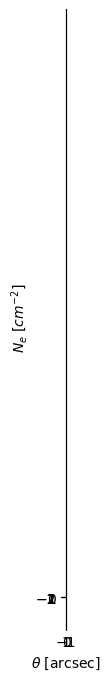

In [228]:
print('We check the shape of Ne so we can fit it')
theta_plot = np.arange(0,3.0,0.1)
plt.plot(theta_plot, [Ne(theta,n0,r0).value for theta in theta_plot])
plt.xlabel('$\\theta$ [arcsec]')
plt.ylabel('$N_e$ [$cm^{-2}$]')
plt.grid()
plt.savefig(my_path + 'image1.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

We fit the following function:
\begin{equation}
\Large N_e^{fit}(\theta) = A n_0 R_0 e^{-\left(\frac{\theta}{B\theta_o}\right)^C}
\end{equation}

In [229]:
def Ne_fit(theta,A,B,C):
    'In cm^{-2}'
    return A*(n0*r0).decompose().to(u.cm**(-2)).value*np.exp(-(theta/B/theta_0)**C)

In [230]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(Ne_fit,theta_plot, [Ne(theta,n0,r0).value for theta in theta_plot])
perr = np.sqrt(np.diag(pcov))

print('A, B and C are dimensionless')
print('A:',popt[0],'\pm',perr[0])
print('B:',popt[1],'\pm',perr[1])
print('C:',popt[2],'\pm',perr[2])

A, B and C are dimensionless
A: 2.00744300029693 \pm 0.0015490484251711103
B: 1.5887225542022732 \pm 0.005062671131146591
C: 1.4308204791467736 \pm 0.007762880407326151


Plot Ne and the fitting


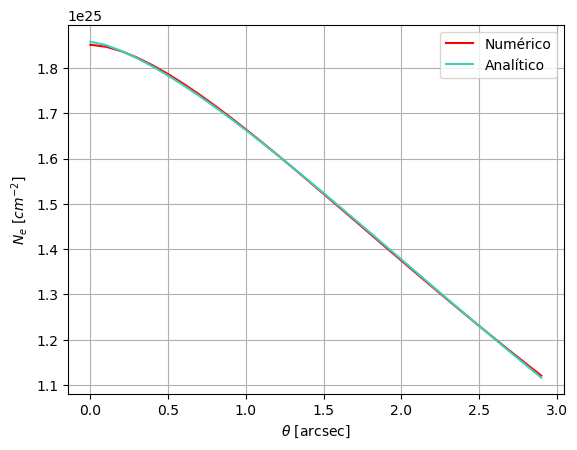

In [231]:
print('Plot Ne and the fitting')
Ne_numerico = [Ne(theta,n0,r0).value for theta in theta_plot]
Ne_analitico = Ne_fit(theta_plot,popt[0],popt[1],popt[2])
plt.plot(theta_plot, Ne_numerico,color='red',label='Numérico')
plt.plot(theta_plot,Ne_analitico,color='#38d1ba',label='Analítico')
plt.xlabel('$\\theta$ [arcsec]')
plt.ylabel('$N_e$ [$cm^{-2}$]')
plt.grid()
plt.legend()
plt.savefig(my_path + 'image2.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

We plot the percentual error in the fitting


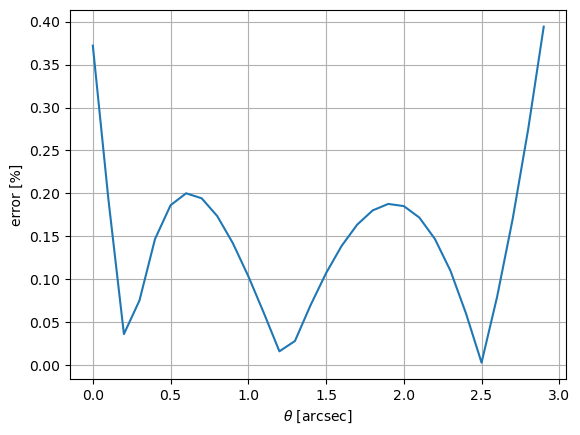

In [232]:
print('We plot the percentual error in the fitting')
plt.plot(theta_plot,(np.abs(Ne_numerico-Ne_analitico) )/Ne_numerico*100.)
plt.xlabel('$\\theta$ [arcsec]')
plt.ylabel('error [%]')
plt.grid()
plt.savefig(my_path + 'image3.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

In [233]:
def pot_plasma(theta,omega):
    'in units of arcsec^2'
    llambda = 2*pi*c_light/omega
    Ne = Ne_fit(theta,popt[0],popt[1],popt[2])/u.cm**2
    pre_return = (Dls/Ds/Dl/2./pi*re*llambda**2*Ne).decompose()
    return pre_return*(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) 

In [234]:
# frequency
#nu = 60.0 * u.MHz
#nu = 80.0 * u.MHz
nu = 130.0 * u.MHz
#nu = 110.0 * u.MHz
#nu = 375.0 * u.MHz

omega = nu*(1.+zl)*2*pi
print('Observation frequency:',omega)
print('Plasma potential (analytic):', pot_plasma(theta_test,omega), 'arcsec^2')

Observation frequency: 980.1769079200154 MHz
Plasma potential (analytic): 0.3855209615506188 arcsec^2


In [235]:
def pot_plasma_num(theta,omega):
    'in units of arcsec^2'
    llambda = 2*pi*c_light/omega
    Nee = Ne(theta,n0,r0)
    pre_return = (Dls/Ds/Dl/2./pi*re*llambda**2*Nee).decompose()
    return pre_return*(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) 

In [236]:
print('Plasma potential (numeric):', pot_plasma_num(theta_test,omega), 'arcsec^2')

Plasma potential (numeric): 0.3851087782454073 arcsec^2


Comparison of analytical and numerical lens potential


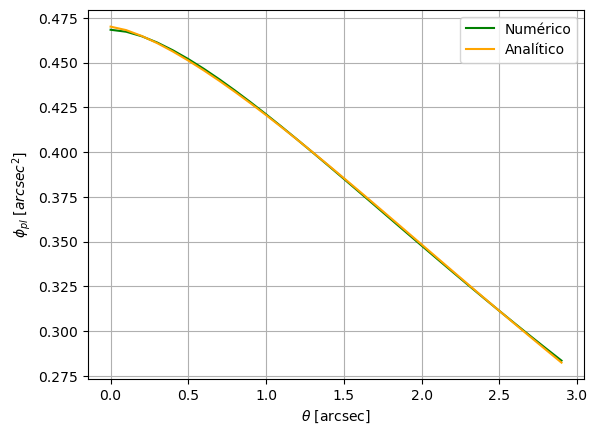

In [237]:
print('Comparison of analytical and numerical lens potential')

pot_plasma_numerico = [pot_plasma_num(theta,omega).value for theta in theta_plot]
pot_plasma_analitico = pot_plasma(theta_plot,omega)

plt.plot(theta_plot,pot_plasma_numerico,color='green',label='Numérico')
plt.plot(theta_plot,pot_plasma_analitico,color='orange',label='Analítico')
plt.xlabel('$\\theta$ [arcsec]')
plt.ylabel('$\phi_{pl}$ [$arcsec^2$]')
plt.grid()
plt.legend()
plt.savefig(my_path + 'image4.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

let's plot the percentual error in the plasma potential (numerical vs analytical)


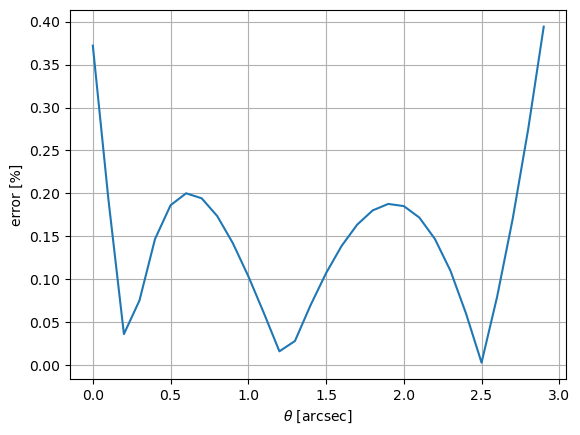

In [238]:
print("let's plot the percentual error in the plasma potential (numerical vs analytical)")
plt.plot(theta_plot,(np.abs(pot_plasma_numerico-pot_plasma_analitico) )/pot_plasma_numerico*100.)
plt.xlabel('$\\theta$ [arcsec]')
plt.ylabel('error [%]')
plt.grid()
plt.savefig(my_path + 'image5.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

## Conclusion: with these setting the plasma potential is just one magnitud order less than the pure gravity lens potential, and then we should expect a noticiable lensing effect by the plasma

In [239]:
print('potencial SIE:', potential_SIE, 'arcsec^2')
print('potencial plasma :', pot_plasma(theta_test,omega), 'arcsec^2')

potencial SIE: 1.1783878721936045 arcsec^2
potencial plasma : 0.3855209615506188 arcsec^2


## Let's solve numerically the lens equation

In [240]:
theta_E_num = theta_E_SIS()
print('theta_E: ',theta_E_num)

A = popt[0]
print('A:',A)
B = popt[1]
print('B:',B)
C = popt[2]
print('C:',C)

psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

print('psi0_plasma: ',psi0_plasma)
print('theta_0: ',theta_0)

elipt = 0.3

print('eta: ',elipt)
print('omega:',omega)

theta_E:  0.7301786792241515
A: 2.00744300029693
B: 1.5887225542022732
C: 1.4308204791467736
psi0_plasma:  0.47012437534577306
theta_0:  2.9240748137875747
eta:  0.3
omega: 980.1769079200154 MHz


In [241]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

In [242]:
# chose a lens model (list of parameterized lens models)
lens_model_list = ['PlasmaExponentialSIE']
#initialize classes with the specific lens models
lensModel = LensModel(lens_model_list)
lensEquationSolver = LensEquationSolver(lensModel)

# zero order
lens_model_list_zero = ['PlasmaExponentialSIE']
lensModel_zero = LensModel(lens_model_list_zero)
lensEquationSolver_zero = LensEquationSolver(lensModel_zero)

## Without plasma

In [243]:
# chose a lens model parameterization
kwargs = {'theta_E':theta_E_num.value,'eta':0*elipt, 'A':A, 'B':B, 'C':C ,'psi0_plasma':0*psi0_plasma.value,\
                'theta_0':theta_0.value}
'theta_E', 'center_x', 'center_y'

kwargs_lens_list = [kwargs]


In [244]:
# solution at zero order in ellipticity. We calculate the image of a point source on the origin
x_image_zero, y_image_zero = lensEquationSolver_zero.image_position_from_source(kwargs_lens=kwargs_lens_list, \
                    sourcePos_x=0.0, sourcePos_y=0.0, min_distance=0.05, search_window=10, \
                    precision_limit=10**(-8), num_iter_max=100,non_linear=True)

radius 1:  0.7301786792241515
radius 2:  0.7301786792241515


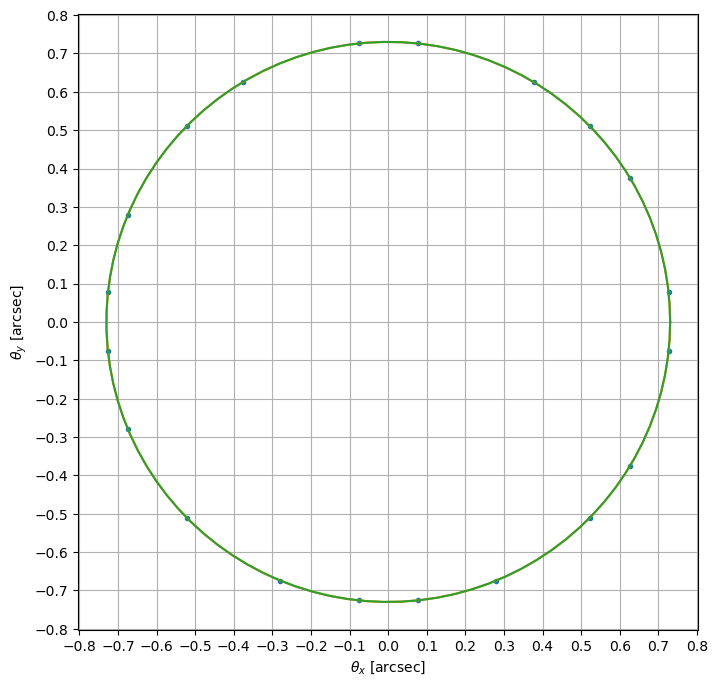

In [245]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 0.1))
ax.set_yticks(np.arange(-2., 2., 0.1))

plt.plot(x_image_zero,y_image_zero,'.')
plt.grid()
radius_1 = np.sqrt(x_image_zero[0]**2+y_image_zero[0]**2)
radius_2 = np.sqrt(x_image_zero[-1]**2+y_image_zero[-1]**2)
print("radius 1: ",radius_1 )
print("radius 2: ",radius_2 )
theta = np.linspace(0,2.*np.pi,100)
x_circle1 = radius_1*np.cos(theta)
y_circle1 = radius_1*np.sin(theta)
x_circle2 = radius_2*np.cos(theta)
y_circle2 = radius_2*np.sin(theta)
plt.plot(x_circle1,y_circle1)
plt.plot(x_circle2,y_circle2)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.show()

In [246]:
# Let's add the ellipticity
kwargs = {'theta_E':theta_E_num.value,'eta':elipt, 'A':A, 'B':B, 'C':C,\
                'psi0_plasma':0.*psi0_plasma.value,'theta_0':theta_0.value}
kwargs_lens_list = [kwargs]

# jet source
n = 120
t = np.linspace(-radius_1*np.sqrt(2)/2,radius_1*np.sqrt(2)/2,n)
a = 1.0
x0 = 0.*radius_1
y0 = 0.*radius_1
x_source_1 = t + x0
y_source_1 = a*t + y0

In [247]:
# compute image position of full model (with numerical options attached)
x_image = []
y_image = []

start = time.time()
for i in range(len(x_source_1)):
    x_pre, y_pre = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens_list, \
                    sourcePos_x=x_source_1[i], sourcePos_y=y_source_1[i], min_distance=0.05, search_window=5, \
                    precision_limit=10**(-8), num_iter_max=100,non_linear=True)
    x_image = np.append(x_image,x_pre)
    y_image = np.append(y_image,y_pre)
    
end = time.time()
print('time: ',end-start)

time:  6.4631452560424805


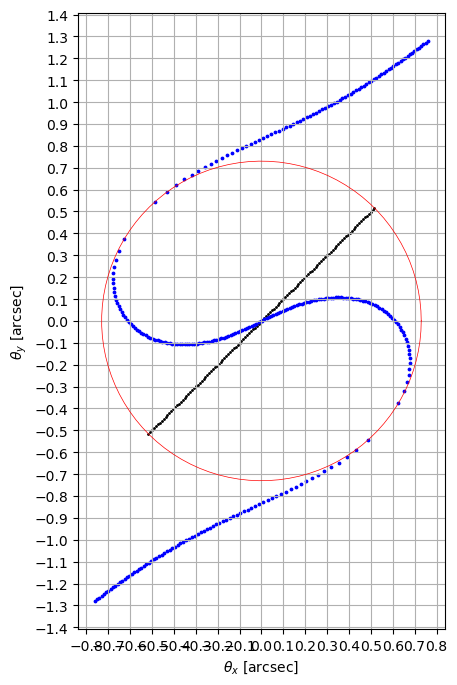

In [248]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 0.1))
ax.set_yticks(np.arange(-2., 2., 0.1))

plt.scatter(x_source_1,y_source_1, s = 1,color='black')
plt.plot(x_circle1,y_circle1,color='red',lw = .5)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image,y_image,color='blue',s = 3)
plt.grid()
plt.show()

In [249]:
mag = lensModel.magnification(x_image, y_image, kwargs = kwargs_lens_list)

In [250]:
lensModelExtensions = LensModelExtensions(lensModel=lensModel)
SSS = lensModelExtensions.critical_curve_caustics(kwargs_lens=kwargs_lens_list, compute_window=5, \
                                                     grid_scale=0.001)

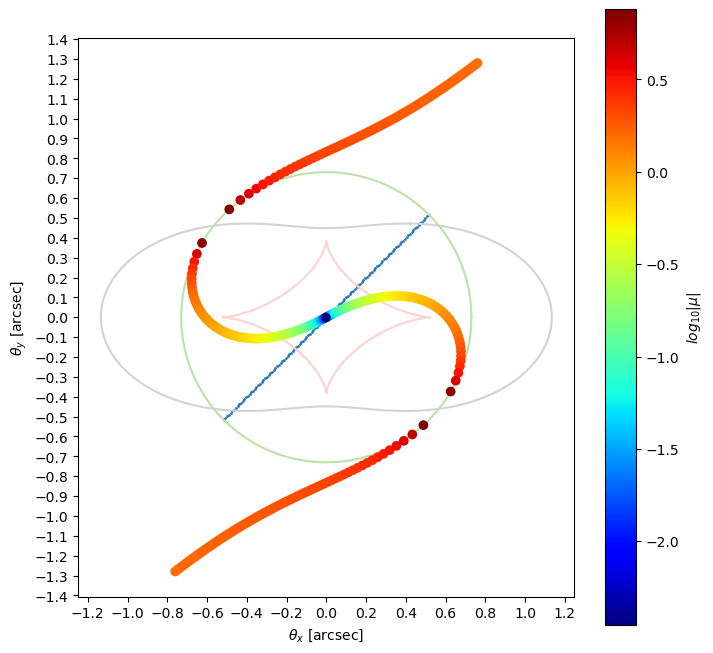

In [251]:
import matplotlib.colors as colors

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 0.2))
ax.set_yticks(np.arange(-2., 2., 0.1))

plt.scatter(x_source_1,y_source_1, s = 1)
plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
plt.plot(SSS[0][0],SSS[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSS[2][0],SSS[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')

plt.scatter(x_image, y_image, c=np.log10((abs(mag))), cmap='jet',zorder=2)
cbar = plt.colorbar()
cbar.set_label('$log_{10}|\mu|$') #the magnification is dimensionless!!!

fig.savefig(my_path + 'image6.png', format='png', dpi = 300, bbox_inches='tight')

plt.show()

In [252]:
radius_3 = 0.5551103128497743

In [253]:
# choose a source position
x0 = -0.2*radius_3
y0 = -0.185*radius_3

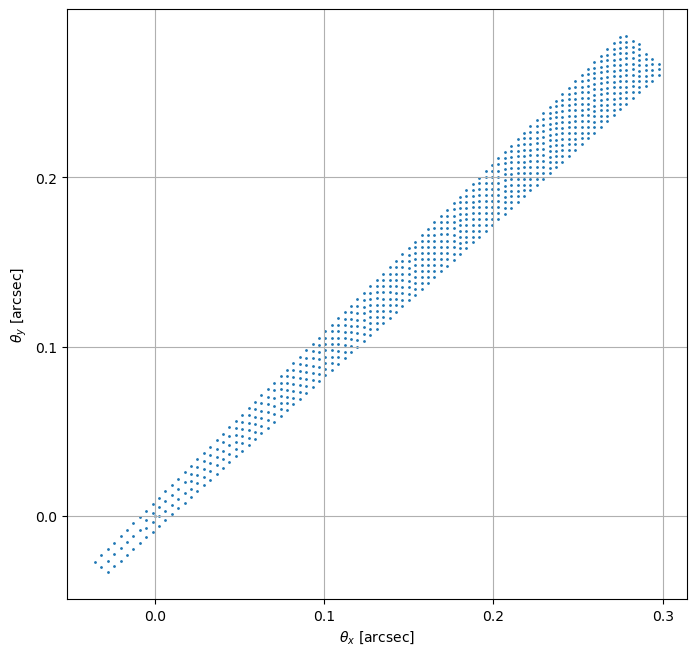

In [254]:
kwargs = {'theta_E':theta_E_num.value,'eta':elipt, 'A':A, 'B':B, 'C':C,\
                'psi0_plasma':0*psi0_plasma.value,'theta_0':theta_0.value}
kwargs_lens_list = [kwargs]

# jet source
n = 110
t = np.linspace(0,radius_3*np.sqrt(2)/2,n)
t2 = np.linspace(0,1.11*radius_3*np.sqrt(2)/2,n)
a = 1.0
b = 0.9
x1 = 0.01*radius_3
y1 = 0.01*radius_3
x_source_1 = t + x0
y_source_1 = a*t + y0
x_source_2 = t2 + x0 + x1
y_source_2 = b*t2 + y0 - y1
        
mesh_x = []
mesh_y = []
n1 = 7  #mientras mas bajo es mas puntos tengo
for j in range(len(x_source_1)):
    for i in range(int(j/n1)):
        mesh_x.append(x_source_1[j]+j*0.02/n)
        z = np.linspace(y_source_2[j]-j*0.02/n, y_source_1[j]+j*0.02/n,int(j/n1))
        mesh_y.append(z[i])
        
mesh__x = []
mesh__y = []
limit = len(mesh_x) - int(n/n1)*6
for i in range(20):
    mesh_x[i] = 0.
    mesh_y[i] = 0.
for i in range(len(mesh_x)):
    if np.sqrt(mesh_x[i]**2+mesh_y[i]**2) < np.sqrt(mesh_x[limit]**2+mesh_y[limit]**2) and np.sqrt(mesh_x[i]**2+mesh_y[i]**2)>0.001:
        mesh__x.append(mesh_x[i])
        mesh__y.append(mesh_y[i])


        
mesh_x = mesh__x
mesh_y = mesh__y

k = np.array(mesh_y).argmin()
mesh_x[k] = 0
mesh_y[k] = 0

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 0.1))
ax.set_yticks(np.arange(-2., 2., 0.1))
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.scatter(mesh_x,mesh_y, s = 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
fig.savefig(my_path + 'image7.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

Having so much points takes lot of computing power. We make the calculation parallel.

In [255]:
def image_position(source):
    x_s, y_s = source
    x_pre, y_pre = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens_list, \
                    sourcePos_x=x_s, sourcePos_y=y_s, min_distance=0.05, search_window=5, \
                    precision_limit=10**(-8), num_iter_max=100,non_linear=True)
    return x_pre, y_pre

def main():
    start_p = time.time()
    x = mesh_x
    y = mesh_y

    with mp.Pool(mp.cpu_count()-1) as pool:
        out = pool.map(image_position, zip(x, y))
        
        xx = []; yy = []
        for i in range(len(out)):
            x = out[i][0]
            xx.append(x)
            y = out[i][1]
            yy.append(y)
        xx = np.concatenate(xx, axis=0)
        yy = np.concatenate(yy, axis=0)
        
    end_p = time.time()
    pool.close()
    print('time : ',(end_p-start_p)/60.,' minutos')
        
    return xx, yy

In [256]:
x_image_paral, y_image_paral = main()

time :  0.08269973595937093  minutos


In [257]:
mag = lensModel.magnification(x_image_paral, y_image_paral, kwargs = kwargs_lens_list)

In [258]:
# Check maximun values of magnification in our solution
k = np.array(mag).argmin()
print(mag[k])
l = np.array(mag).argmax()
print(mag[l])

-259079132.1176546
17.192573134638067


In [259]:
# Take off most magnified point to make the colormap useful
mag[k] = 0

<ipython-input-260-459c2a53ae75>:15: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(x_image_paral, y_image_paral, c=np.log10((abs(mag))), cmap='jet', s = 3,zorder=2)


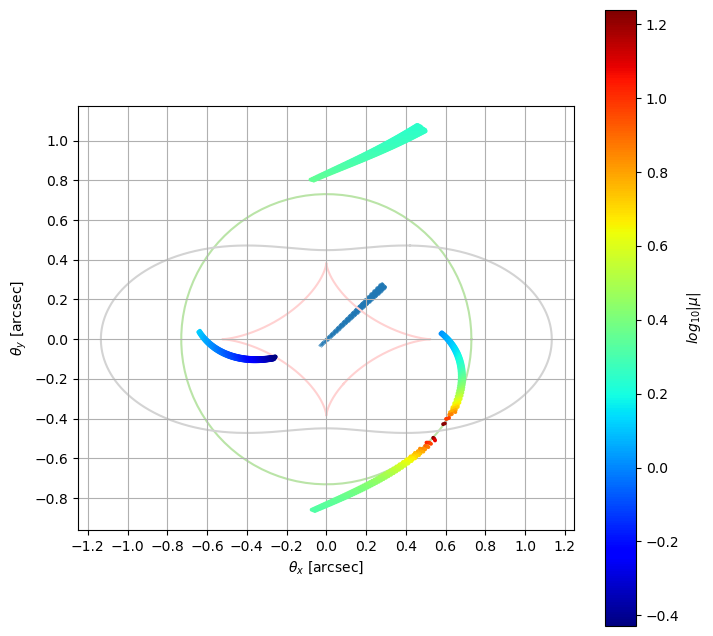

In [260]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 0.2))
ax.set_yticks(np.arange(-2., 2., 0.2))

plt.scatter(mesh_x,mesh_y, s =.1)
plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
plt.plot(SSS[0][0],SSS[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSS[2][0],SSS[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')

plt.gca().set_aspect('equal', adjustable='box')

plt.scatter(x_image_paral, y_image_paral, c=np.log10((abs(mag))), cmap='jet', s = 3,zorder=2)
cbar = plt.colorbar()
cbar.set_label('$log_{10}|\mu|$')
plt.grid()

fig.savefig(my_path + 'image8.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

## Let's add a light profile

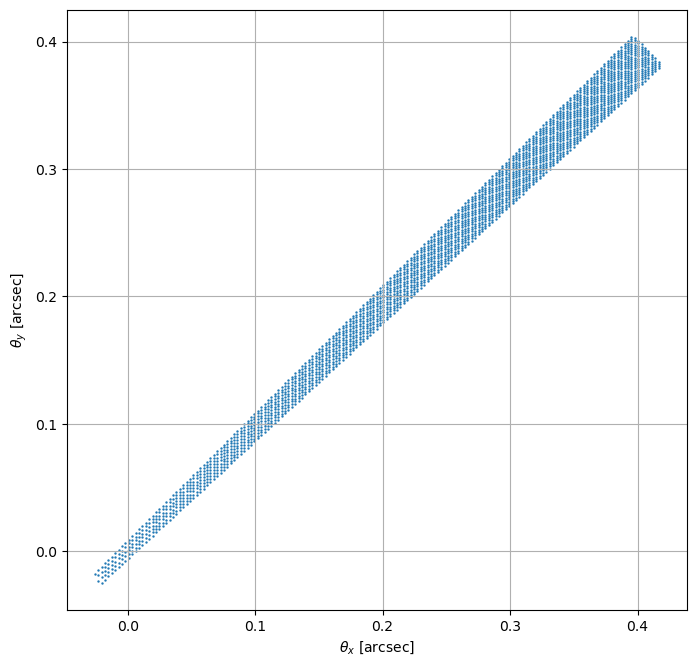

In [261]:
kwargs = {'theta_E':theta_E_num.value,'eta':elipt, 'A':A, 'B':B, 'C':C,\
                'psi0_plasma':0*psi0_plasma.value,'theta_0':theta_0.value}
kwargs_lens_list = [kwargs]

# jet source
n = 200
t = np.linspace(0,1.3*radius_3*np.sqrt(2)/2,n)
t2 = np.linspace(0,1.3*1.11*radius_3*np.sqrt(2)/2,n)
a = 1.0
b = 0.9

x0 = -0.2*radius_3
y0 = -0.185*radius_3

x1 = 0.01*radius_3
y1 = 0.01*radius_3
x_source_1 = t + x0
y_source_1 = a*t + y0
x_source_2 = t2 + x0 + x1
y_source_2 = b*t2 + y0 - y1
        
mesh_x = []
mesh_y = []
n1 = 7  #n1 lower implies a higher number of points
for j in range(len(x_source_1)):
    for i in range(int(j/n1)):
        mesh_x.append(x_source_1[j]+j*0.02/n)
        z = np.linspace(y_source_2[j]-j*0.02/n, y_source_1[j]+j*0.02/n,int(j/n1))
        mesh_y.append(z[i])
        
mesh__x = []
mesh__y = []
limit = len(mesh_x) - int(n/n1)
for i in range(61):
    mesh_x[i] = 0.
    mesh_y[i] = 0.
for i in range(len(mesh_x)):
    if np.sqrt(mesh_x[i]**2+mesh_y[i]**2) < np.sqrt(mesh_x[limit]**2+mesh_y[limit]**2) and np.sqrt(mesh_x[i]**2+mesh_y[i]**2)>0.001:
        mesh__x.append(mesh_x[i])
        mesh__y.append(mesh_y[i])
        
mesh_x = mesh__x
mesh_y = mesh__y

k = np.array(mesh_y).argmin()
mesh_x[k] = 0
mesh_y[k] = 0

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., .1))
ax.set_yticks(np.arange(-2., 2., .1))
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.scatter(mesh_x,mesh_y, s = .5, marker = 'o')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()

fig.savefig(my_path + 'image9.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

In [262]:
# count blobes from smaller to bigger
alpha = -(np.pi/4 + 1.5* np.pi/180)

rx_1 = 0.017/2
ry_1 = 5*rx_1
cx_1 = 0.12
cy_1 = 0.11+0.01*radius_3
rx_2 = 0.022/2
ry_2 = 5*rx_1
cx_2 = 0.18 
cy_2 = 0.167+0.01*radius_3
rx_3 = 0.027/2
ry_3 = 5*rx_3
cx_3 = 0.26
cy_3 = 0.245+0.01*radius_3 
rx_4 = 0.045/2
ry_4 = 4*rx_4
cx_4 = 0.37 
cy_4 = 0.35+0.01*radius_3   
mesh_light = []
for i in range(len(mesh_x)):
    if ( (mesh_x[i]-cx_1)*np.cos(alpha) + (mesh_y[i]-cy_1)*np.sin(alpha) )**2/rx_1**2 + \
( (mesh_x[i]-cx_1)*np.sin(alpha) - (mesh_y[i]-cy_1)*np.cos(alpha) )**2/ry_1**2 < 1:
        r = np.sqrt(((mesh_x[i]-cx_1)*np.cos(alpha) + (mesh_y[i]-cy_1)*np.sin(alpha) )**2/rx_1**2 + \
( (mesh_x[i]-cx_1)*np.sin(alpha) - (mesh_y[i]-cy_1)*np.cos(alpha) )**2/ry_1**2)
        light = np.exp(-r**2)
        mesh_light.append(light)
    elif ( (mesh_x[i]-cx_2)*np.cos(alpha) + (mesh_y[i]-cy_2)*np.sin(alpha) )**2/rx_2**2 + \
( (mesh_x[i]-cx_2)*np.sin(alpha) - (mesh_y[i]-cy_2)*np.cos(alpha) )**2/ry_2**2 < 1:
        r = np.sqrt(((mesh_x[i]-cx_2)*np.cos(alpha) + (mesh_y[i]-cy_2)*np.sin(alpha) )**2/rx_2**2 + \
( (mesh_x[i]-cx_2)*np.sin(alpha) - (mesh_y[i]-cy_2)*np.cos(alpha) )**2/ry_2**2)
        light = np.exp(-r**2)
        mesh_light.append(light)
    elif ( (mesh_x[i]-cx_3)*np.cos(alpha) + (mesh_y[i]-cy_3)*np.sin(alpha) )**2/rx_3**2 + \
( (mesh_x[i]-cx_3)*np.sin(alpha) - (mesh_y[i]-cy_3)*np.cos(alpha) )**2/ry_3**2 < 1:
        r = np.sqrt(((mesh_x[i]-cx_3)*np.cos(alpha) + (mesh_y[i]-cy_3)*np.sin(alpha) )**2/rx_3**2 + \
( (mesh_x[i]-cx_3)*np.sin(alpha) - (mesh_y[i]-cy_3)*np.cos(alpha) )**2/ry_3**2)
        light = np.exp(-r**2)
        mesh_light.append(light)
    elif ( (mesh_x[i]-cx_4)*np.cos(alpha) + (mesh_y[i]-cy_4)*np.sin(alpha) )**2/rx_4**2 + \
( (mesh_x[i]-cx_4)*np.sin(alpha) - (mesh_y[i]-cy_4)*np.cos(alpha) )**2/ry_4**2 < 1:
        r = np.sqrt(((mesh_x[i]-cx_4)*np.cos(alpha) + (mesh_y[i]-cy_4)*np.sin(alpha) )**2/rx_4**2 + \
( (mesh_x[i]-cx_4)*np.sin(alpha) - (mesh_y[i]-cy_4)*np.cos(alpha) )**2/ry_4**2)
        light = np.exp(-r**2)
        mesh_light.append(light)    
    else:
        light = 1/np.e
        mesh_light.append(light)


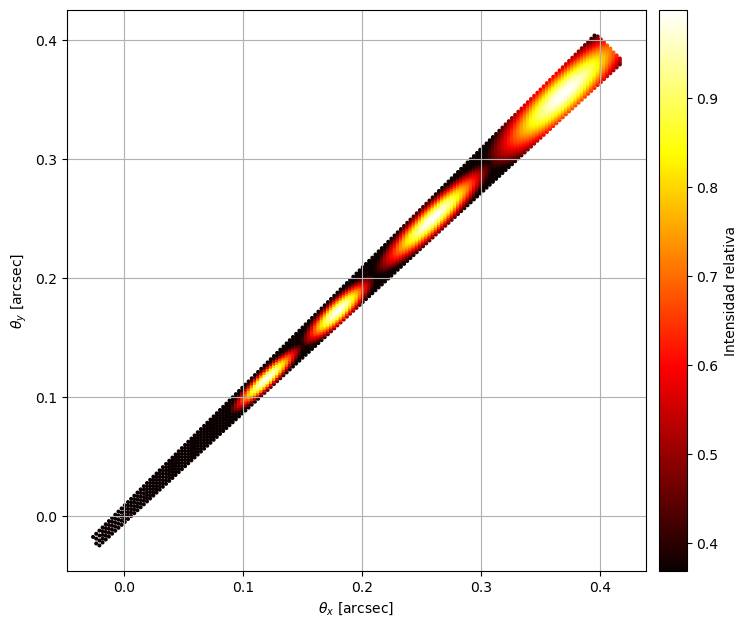

In [263]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., .1))
ax.set_yticks(np.arange(-2., 2., .1))
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.scatter(mesh_x, mesh_y, c=mesh_light, cmap='hot', s = 3.5)
cbar = plt.colorbar(fraction=0.0453, pad=0.02)
cbar.set_label('Intensidad relativa')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
fig.savefig(my_path + 'image10.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

In [264]:
# with a light profile the calculation of images has to be modified
def image_position(source):
    x_s, y_s,light = source
    x_pre, y_pre = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens_list, \
                    sourcePos_x=x_s, sourcePos_y=y_s, min_distance=0.05, search_window=5, \
                    precision_limit=10**(-8), num_iter_max=100,non_linear=True)
    light_pre = []
    for k in range(len(x_pre)):
        light_pre = np.append(light_pre,light)
    return x_pre, y_pre, light_pre

def main(x1,x2,x3):
    start_p = time.time()
    x = x1
    y = x2
    l = x3
    
    with mp.Pool(mp.cpu_count()-1) as pool:
        out = pool.map(image_position, zip(x,y,l))
        
        xx = []; yy = []; ll = []
        for i in range(len(out)):
            x = out[i][0]
            xx.append(x)
            y = out[i][1]
            yy.append(y)
            l = out[i][2]
            ll.append(l)
        xx = np.concatenate(xx, axis=0)
        yy = np.concatenate(yy, axis=0)
        ll = np.concatenate(ll, axis=0)
    end_p = time.time()
    pool.close()
    print('time: ',(end_p-start_p)/60.,' minutes')
        
    return xx, yy, ll

### $\eta = 0$

In [265]:
kwargs = {'theta_E':theta_E_num.value,'eta':0*elipt, 'A':A, 'B':B, 'C':C,\
                'psi0_plasma':0*psi0_plasma.value,'theta_0':theta_0.value}
kwargs_lens_list = [kwargs]

In [266]:
x_image, y_image, light_image = main(mesh_x,mesh_y,mesh_light)

time:  0.3473369518915812  minutes


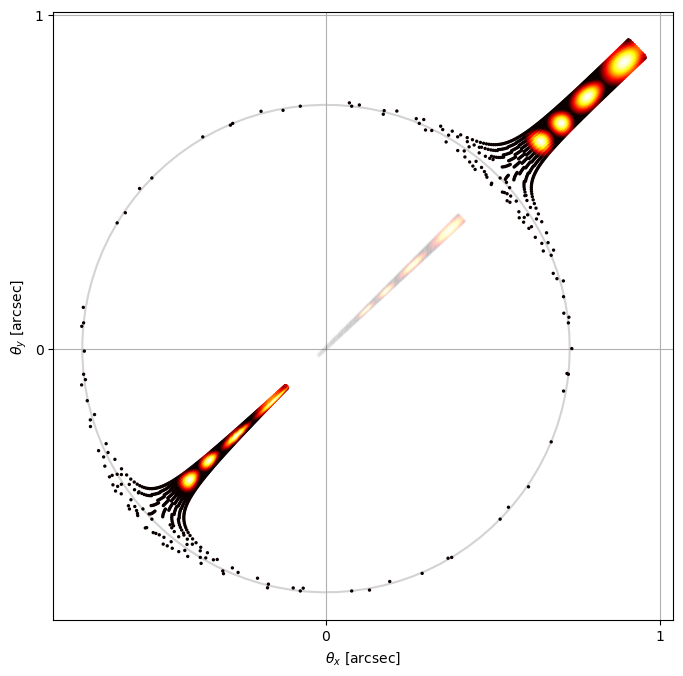

In [267]:
light = light_image

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x,mesh_y, s =.0005, c=mesh_light, cmap='hot',zorder = 2)
plt.plot(x_circle1,y_circle1,color='#d3d3d3',lw = 1.5,zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image, y_image, c=light, cmap='hot', s = 2,zorder = 2)
plt.grid()
fig.savefig(my_path + 'image10.5.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

In [268]:
thetarot = -np.pi/4. + np.pi/180

mesh_x_rot = np.array(mesh_x)*np.cos(thetarot) -  np.array(mesh_y)*np.sin(thetarot)  + .05
mesh_y_rot = np.array(mesh_x)*np.sin(thetarot) +  np.array(mesh_y)*np.cos(thetarot)  + .2

In [269]:
kwargs = {'theta_E':theta_E_num.value,'eta':0*elipt, 'A':A, 'B':B, 'C':C,\
                'psi0_plasma':0*psi0_plasma.value,'theta_0':theta_0.value}
kwargs_lens_list = [kwargs]

In [270]:
x_image, y_image, light_image = main(mesh_x_rot,mesh_y_rot,mesh_light)

time:  0.1669590989748637  minutes


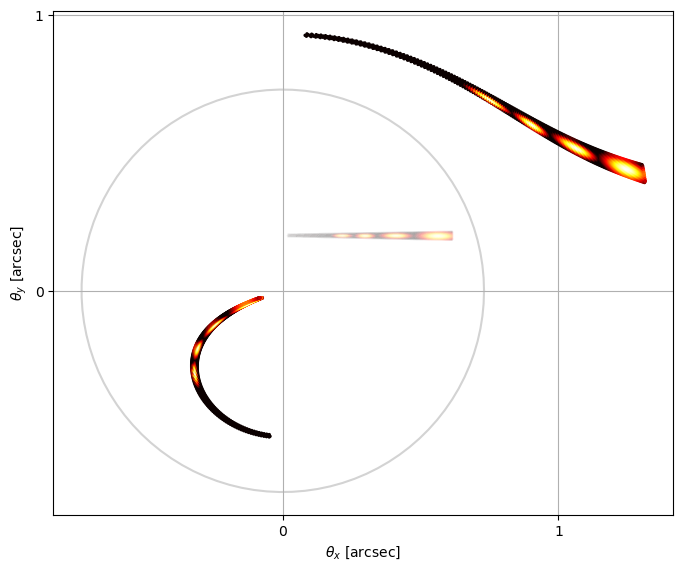

In [271]:
light = light_image

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x_rot,mesh_y_rot, s =.0005, c=mesh_light, cmap='hot',zorder = 2)
plt.plot(x_circle1,y_circle1,color='#d3d3d3',lw = 1.5,zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image, y_image, c=light, cmap='hot', s = 2,zorder = 2)
plt.grid()
fig.savefig(my_path + 'image10.6.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

### $\eta = 0.3$

In [272]:
kwargs = {'theta_E':theta_E_num.value,'eta':elipt, 'A':A, 'B':B, 'C':C,\
                'psi0_plasma':0*psi0_plasma.value,'theta_0':theta_0.value}
kwargs_lens_list = [kwargs]

In [273]:
x_image, y_image, light_image = main(mesh_x,mesh_y,mesh_light)

time:  0.27636621793111166  minutes


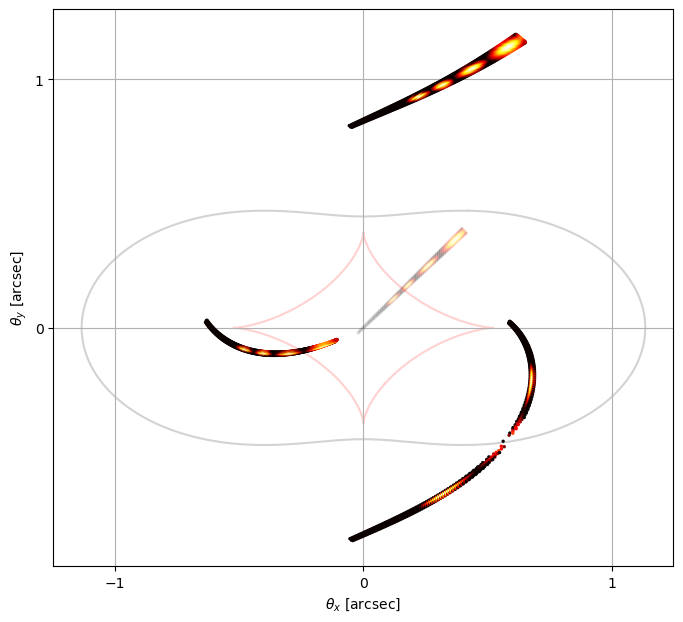

In [274]:
light = light_image

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x,mesh_y, s =.0005, c=mesh_light, cmap='hot',zorder = 2)
#plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
plt.plot(SSS[0][0],SSS[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSS[2][0],SSS[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image, y_image, c=light, cmap='hot', s = 2,zorder = 2)
plt.grid()
fig.savefig(my_path + 'image11.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

El primer lóbulo está dentro de la cáustica y produce 4 imágenes. Los otros producen solo 2.

In [275]:
x_image_rot, y_image_rot, light_image = main(mesh_x_rot,mesh_y_rot,mesh_light)

time:  0.2499058763186137  minutes


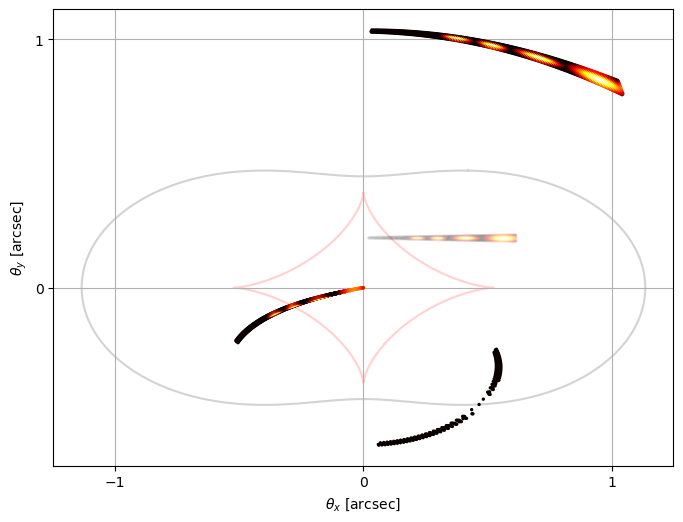

In [276]:
light = light_image

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x_rot,mesh_y_rot, s =.0005, c=mesh_light, cmap='hot',zorder = 2)
#plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
plt.plot(SSS[0][0],SSS[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSS[2][0],SSS[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_rot, y_image_rot, c=light, cmap='hot', s = 2,zorder = 2)
cbar.set_label('$uio$')
plt.grid()
fig.savefig(my_path + 'image11.5.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

In [277]:
mesh_x_2 = -np.array(mesh_x)
mesh_y_2 = -np.array(mesh_y)

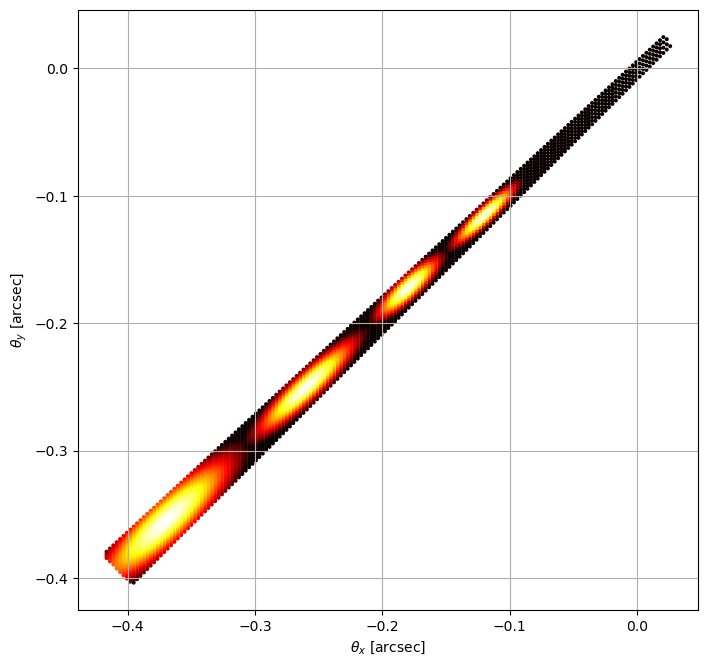

In [278]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., .1))
ax.set_yticks(np.arange(-2., 2., .1))

ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.scatter(mesh_x_2, mesh_y_2, c=mesh_light, cmap='hot', s = 3.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
fig.savefig(my_path + 'image12.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

In [279]:
x_image_2, y_image_2, light_image = main(mesh_x_2,mesh_y_2,mesh_light)

time:  0.27083745002746584  minutes


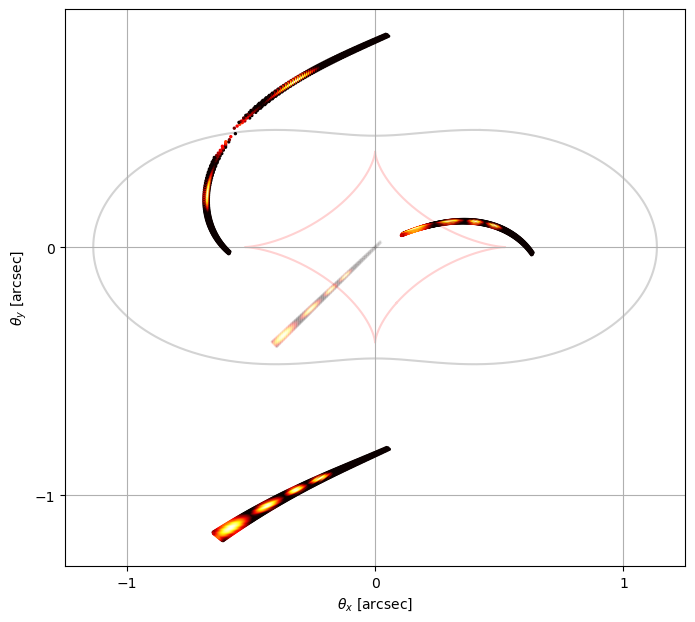

In [280]:
light = light_image

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x_2,mesh_y_2, s =.0005, c=mesh_light, cmap='hot',zorder = 2)
#plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
plt.plot(SSS[0][0],SSS[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSS[2][0],SSS[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_2, y_image_2, c=light, cmap='hot', s = 2,zorder = 2)
fig.savefig(my_path + 'image13.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

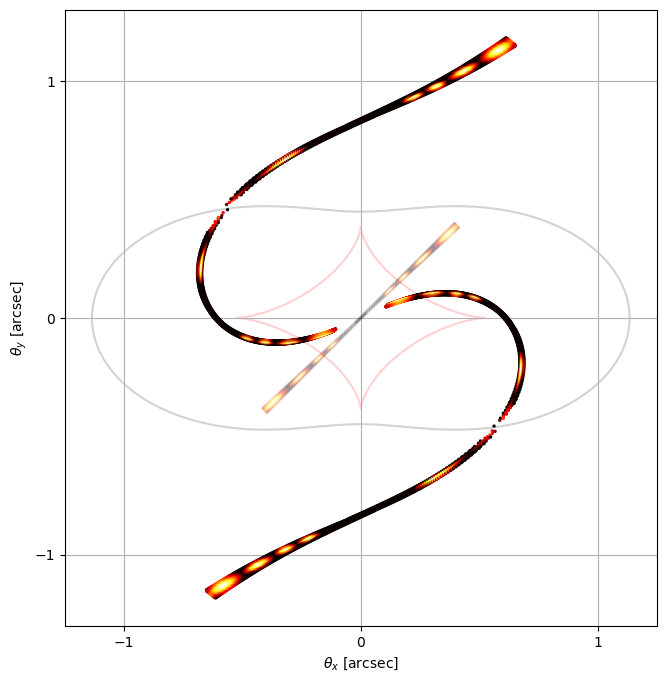

In [281]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x,mesh_y, s =.0005, c=mesh_light, cmap='hot',zorder = 2)
plt.scatter(mesh_x_2,mesh_y_2, s =.0005, c=mesh_light, cmap='hot',zorder = 2)
#plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
plt.plot(SSS[0][0],SSS[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSS[2][0],SSS[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image, y_image, c=light, cmap='hot', s = 2,zorder = 2)
plt.scatter(x_image_2, y_image_2, c=light, cmap='hot', s = 2,zorder = 2)
plt.grid()
fig.savefig(my_path + 'image14.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

In [282]:
mesh_x_total = np.concatenate((mesh_x,mesh_x_2))
mesh_y_total = np.concatenate((mesh_y,mesh_y_2))
mesh_light_total = np.concatenate((mesh_light,mesh_light))

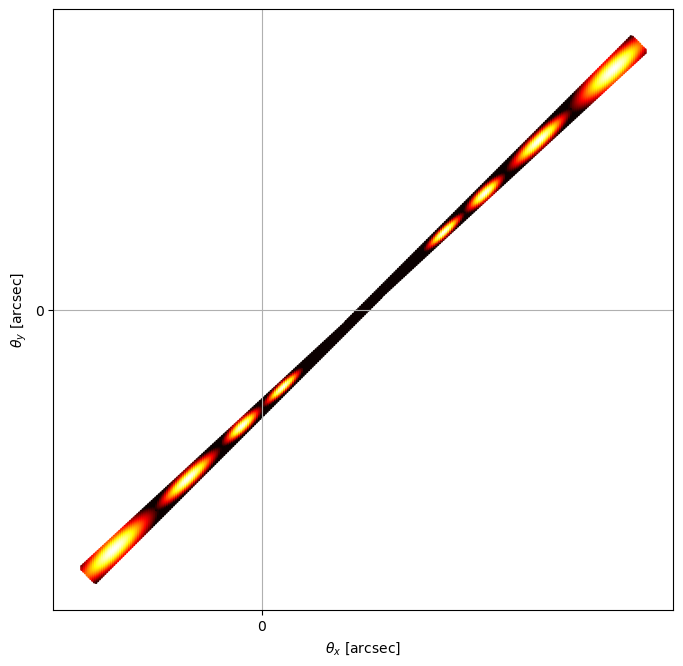

In [283]:
mesh_x_total_shifted = mesh_x_total + 0.15

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x_total_shifted,mesh_y_total, c=mesh_light_total, cmap='hot', s = 1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
fig.savefig(my_path + 'image15.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

In [284]:
x_image_shifted, y_image_shifted, light_shifted = main(mesh_x_total_shifted,mesh_y_total,mesh_light_total)

time:  0.5399369080861409  minutes


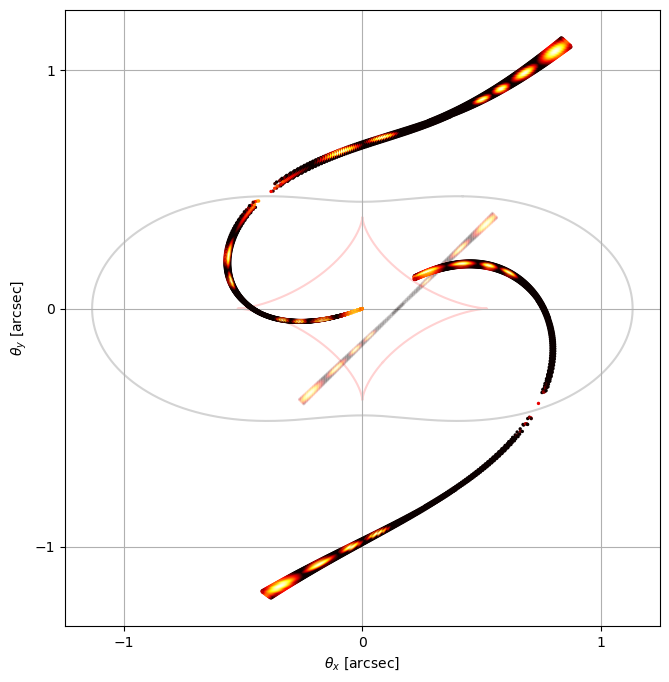

In [285]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x_total_shifted,mesh_y_total, s =.0005, c=mesh_light_total, cmap='hot',zorder = 2)
#plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
plt.plot(SSS[0][0],SSS[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSS[2][0],SSS[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_shifted, y_image_shifted, c=light_shifted, cmap='hot', s = 2,zorder = 2)
plt.grid()
fig.savefig(my_path + 'image16.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

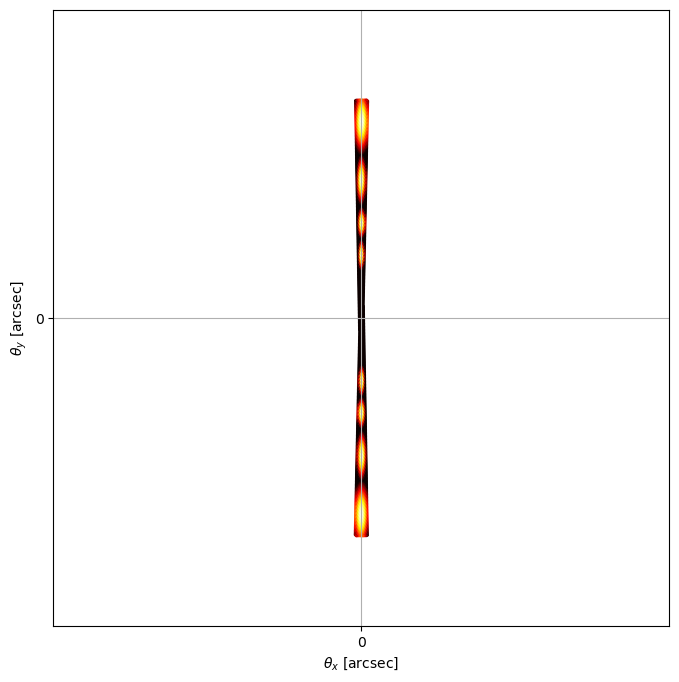

In [286]:
thetarot = np.pi/4. + np.pi/180
mesh_x_rot = mesh_x_total*np.cos(thetarot) -  mesh_y_total*np.sin(thetarot) 
mesh_y_rot = mesh_x_total*np.sin(thetarot) +  mesh_y_total*np.cos(thetarot)

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))
plt.scatter(mesh_x_rot,mesh_y_rot , c=mesh_light_total, cmap='hot', s = 1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
ax.set_xlim([-.8, .8])
ax.set_ylim([-.8, .8])
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
fig.savefig(my_path + 'image17.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

In [287]:
x_image_rot, y_image_rot, light_rot = main(mesh_x_rot,mesh_y_rot,mesh_light_total)

time:  0.5090322454770406  minutes


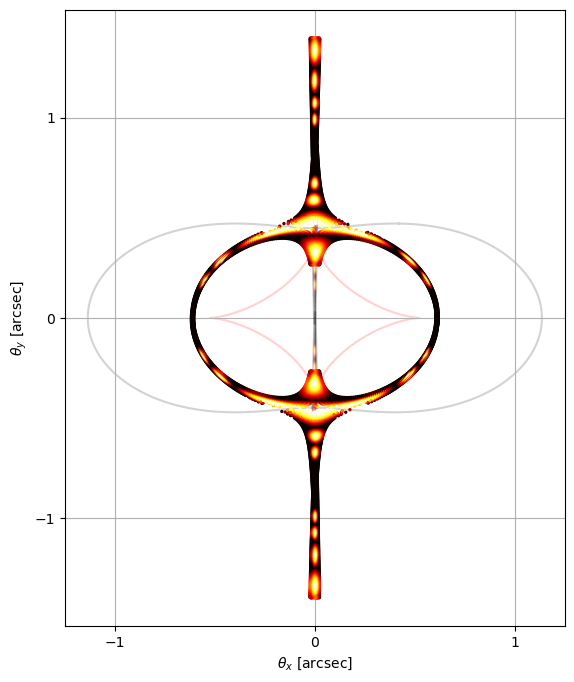

In [288]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x_rot,mesh_y_rot, s =.0005, c=mesh_light_total, cmap='hot',zorder = 2)
#plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
plt.plot(SSS[0][0],SSS[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSS[2][0],SSS[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_rot, y_image_rot, c=light_rot, cmap='hot', s = 2,zorder = 2)
plt.grid()
fig.savefig(my_path + 'image18.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

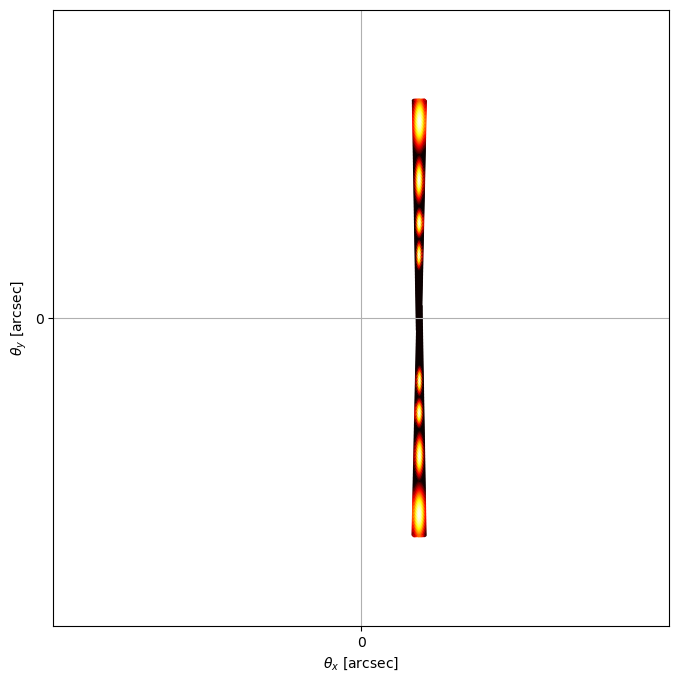

In [289]:
thetarot = np.pi/4.
mesh_x_rot_shifted = mesh_x_rot + 0.15
mesh_y_rot_shifted = mesh_y_rot

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))
plt.scatter(mesh_x_rot_shifted,mesh_y_rot_shifted , c=mesh_light_total, cmap='hot', s = 1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
ax.set_xlim([-.8, .8])
ax.set_ylim([-.8, .8])
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
fig.savefig(my_path + 'image19.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

In [290]:
x_image_rot_shifted, y_image_rot_shifted, light_rot = main(mesh_x_rot_shifted,mesh_y_rot_shifted,mesh_light_total)

time:  0.4292391339937846  minutes


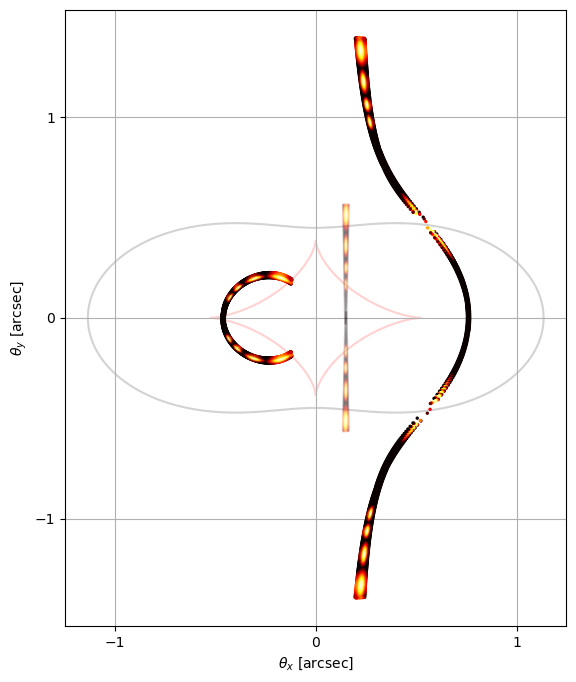

In [291]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))
plt.scatter(mesh_x_rot_shifted,mesh_y_rot_shifted, s =.0005, c=mesh_light_total, cmap='hot',zorder = 2)

#plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
plt.plot(SSS[0][0],SSS[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSS[2][0],SSS[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_rot_shifted, y_image_rot_shifted, c=light_rot, cmap='hot', s = 2,zorder = 2)
plt.grid()
fig.savefig(my_path + 'image20.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

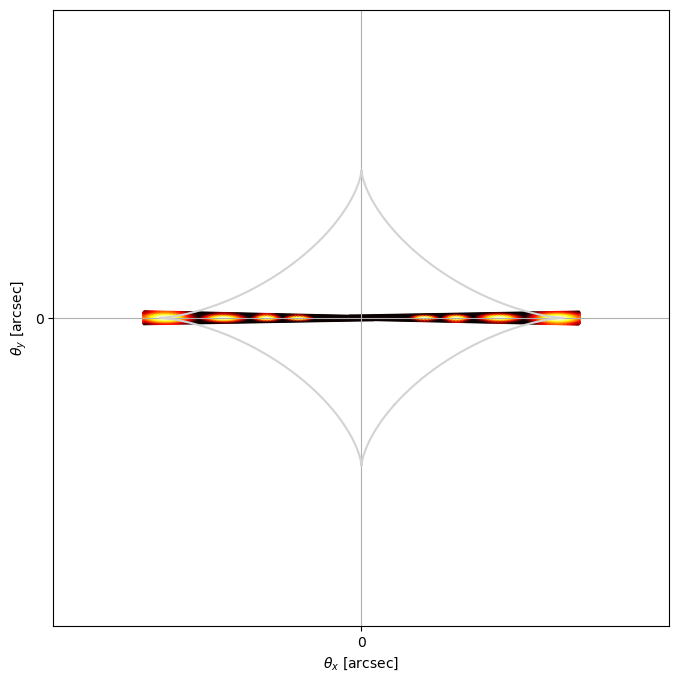

In [292]:
thetarot_2 = -np.pi/4. + np.pi/180.
mesh_x_rot_2 = mesh_x_total*np.cos(thetarot_2) -  mesh_y_total*np.sin(thetarot_2) 
mesh_y_rot_2 = mesh_x_total*np.sin(thetarot_2) +  mesh_y_total*np.cos(thetarot_2)

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))
plt.scatter(mesh_x_rot_2,mesh_y_rot_2 , c=mesh_light_total, cmap='hot', s = 1)
plt.plot(SSS[2][0],SSS[3][0], color = '#d3d3d3')
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
ax.set_xlim([-.8, .8])
ax.set_ylim([-.8, .8])
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
fig.savefig(my_path + 'image21.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

In [293]:
x_image_rot_2, y_image_rot_2, light_rot_2 = main(mesh_x_rot_2,mesh_y_rot_2,mesh_light_total)

time:  0.7014214674631755  minutes


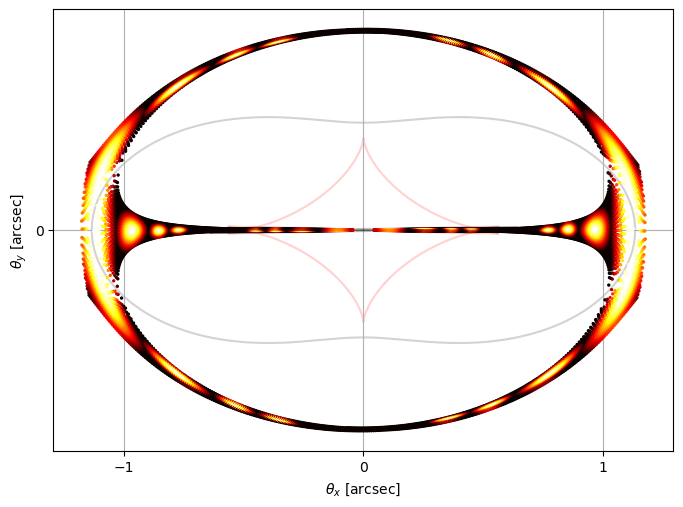

In [294]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x_rot_2,mesh_y_rot_2, s =.0005, c=mesh_light_total, cmap='hot',zorder = 2)
#plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
plt.plot(SSS[0][0],SSS[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSS[2][0],SSS[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_rot_2, y_image_rot_2, c=light_rot_2, cmap='hot', s = 2,zorder = 2)
plt.grid()
fig.savefig(my_path + 'image22.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

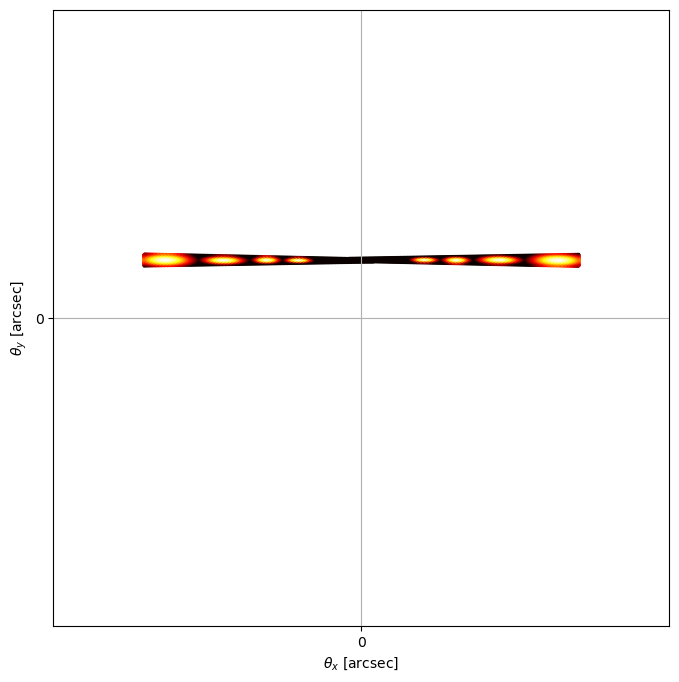

In [295]:
mesh_x_rot_2_shifted = mesh_x_rot_2
mesh_y_rot_2_shifted = mesh_y_rot_2 + 0.15

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))
plt.scatter(mesh_x_rot_2_shifted,mesh_y_rot_2_shifted , c=mesh_light_total, cmap='hot', s = 1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
ax.set_xlim([-.8, .8])
ax.set_ylim([-.8, .8])
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
fig.savefig(my_path + 'image23.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

In [296]:
x_image_rot_2_shifted, y_image_rot_2_shifted, light_rot_2_shifted = main(mesh_x_rot_2_shifted,mesh_y_rot_2_shifted,mesh_light_total)

time:  0.5172695994377137  minutes


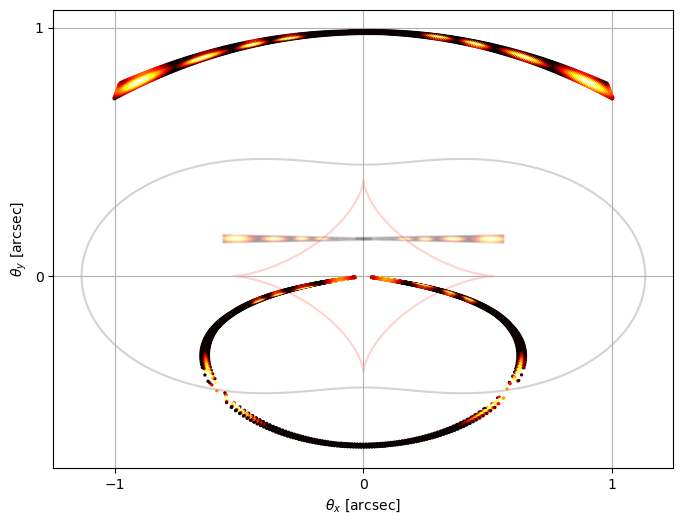

In [297]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))
plt.scatter(mesh_x_rot_2_shifted,mesh_y_rot_2_shifted, s =.0005, c=mesh_light_total, cmap='hot',zorder = 2)

#plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
plt.plot(SSS[0][0],SSS[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSS[2][0],SSS[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_rot_2_shifted, y_image_rot_2_shifted, c=light_rot_2_shifted, cmap='hot', s = 2,zorder = 2)
plt.grid()
fig.savefig(my_path + 'image24.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

## With plasma

In [298]:
kwargs = {'theta_E':theta_E_num.value,'eta':0*elipt, 'A':A, 'B':B, 'C':C ,'psi0_plasma':psi0_plasma.value,\
                'theta_0':theta_0.value}
kwargs_lens_list = [kwargs]

In [299]:
# solution at zero order in eta
x_image_zero_p, y_image_zero_p = lensEquationSolver_zero.image_position_from_source(kwargs_lens=kwargs_lens_list, \
                    sourcePos_x=0.0, sourcePos_y=0.0, min_distance=0.05, search_window=10, \
                    precision_limit=10**(-8), num_iter_max=100,non_linear=True)

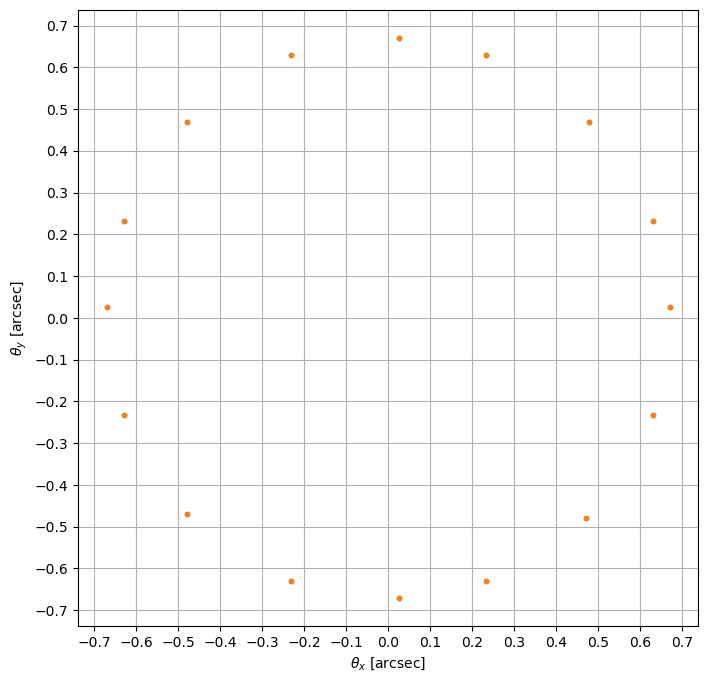

In [300]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 0.1))
ax.set_yticks(np.arange(-2., 2., 0.1))

plt.plot(x_image_zero_p,y_image_zero_p,'.')
plt.grid()
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.plot(x_image_zero_p,y_image_zero_p,'.')
plt.show()

radius 1:  0.6710903313244306
radius 2:  0.6710903313244306


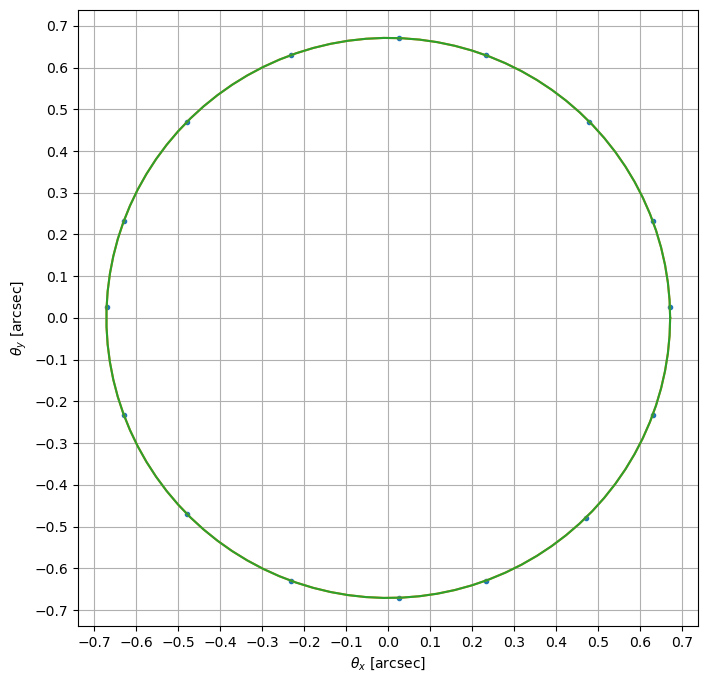

In [301]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 0.1))
ax.set_yticks(np.arange(-2., 2., 0.1))

plt.plot(x_image_zero_p,y_image_zero_p,'.')
plt.grid()
radius_1_p = np.sqrt(x_image_zero_p[0]**2+y_image_zero_p[0]**2)
radius_2_p = np.sqrt(x_image_zero_p[-1]**2+y_image_zero_p[-1]**2)
print("radius 1: ",radius_1_p )
print("radius 2: ",radius_2_p )
theta = np.linspace(0,2.*np.pi,100)
x_circle1_p = radius_1_p*np.cos(theta)
y_circle1_p = radius_1_p*np.sin(theta)
x_circle2_p = radius_2_p*np.cos(theta)
y_circle2_p = radius_2_p*np.sin(theta)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.plot(x_circle1_p,y_circle1_p)
plt.plot(x_circle2_p,y_circle2_p)
plt.show()

In [316]:
kwargs = {'theta_E':theta_E_num.value,'eta':elipt, 'A':A, 'B':B, 'C':C,\
                'psi0_plasma':psi0_plasma.value,'theta_0':theta_0.value}
kwargs_lens_list = [kwargs]

In [317]:
thetarot = -np.pi/8. + np.pi/180

mesh_x_rot = np.array(mesh_x)*np.cos(thetarot) -  np.array(mesh_y)*np.sin(thetarot)  + .05
mesh_y_rot = np.array(mesh_x)*np.sin(thetarot) +  np.array(mesh_y)*np.cos(thetarot)  - .2

In [318]:
x_image_rot_p, y_image_rot_p, light_p = main(mesh_x_rot,mesh_y_rot,mesh_light)

time:  0.25813337564468386  minutes


In [319]:
SSSp = lensModelExtensions.critical_curve_caustics(kwargs_lens=kwargs_lens_list, compute_window=5, \
                                                     grid_scale=0.001)

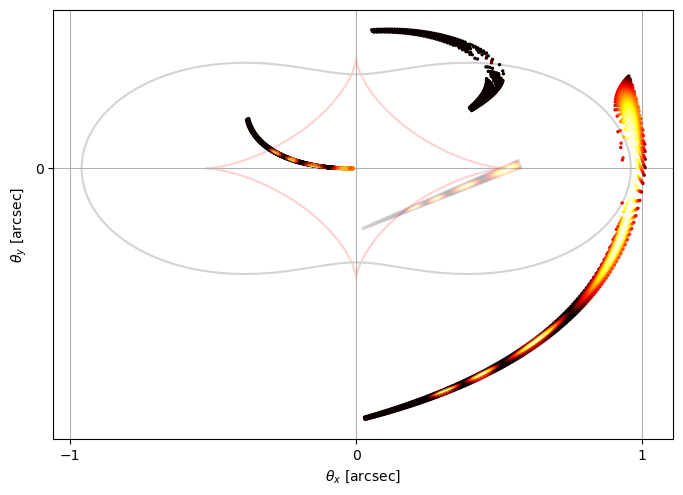

In [329]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x_rot,mesh_y_rot, s =.0005, c=mesh_light, cmap='hot',zorder = 2)
#plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
#plt.plot(x_circle1_p,y_circle1_p,color='#bae4a7',lw = 1.5,zorder=1)
# plt.plot(SSS[0][0],SSS[1][0], color = '#d3d3d3',zorder=1)
# plt.plot(SSS[2][0],SSS[3][0], color = '#d3d3d3',zorder=1)
plt.plot(SSSp[2][0],SSSp[3][0], color = '#ffd1d1',zorder=1)
plt.plot(SSSp[0][0],SSSp[1][0], color = '#d3d3d3',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_rot_p, y_image_rot_p, c=light_p, cmap='hot', s = 2,zorder = 2)
plt.grid()
fig.savefig(my_path + 'image25.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

In [338]:
nu = 60.0 * u.MHz
#nu = 130.0 * u.MHz
#nu = 110.0 * u.MHz
#nu = 375.0 * u.MHz

omega = nu*(1.+zl)*2*pi
psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

In [339]:
kwargs = {'theta_E':theta_E_num.value,'eta':elipt, 'A':A, 'B':B, 'C':C,\
                'psi0_plasma':psi0_plasma.value,'theta_0':theta_0.value}
kwargs_lens_list = [kwargs]

In [340]:
x_image_rot_p2, y_image_rot_p2, light_p2 = main(mesh_x_rot,mesh_y_rot,mesh_light)

time:  0.23819096485773722  minutes


In [341]:
SSSp2 = lensModelExtensions.critical_curve_caustics(kwargs_lens=kwargs_lens_list, compute_window=5, \
                                                     grid_scale=0.001)

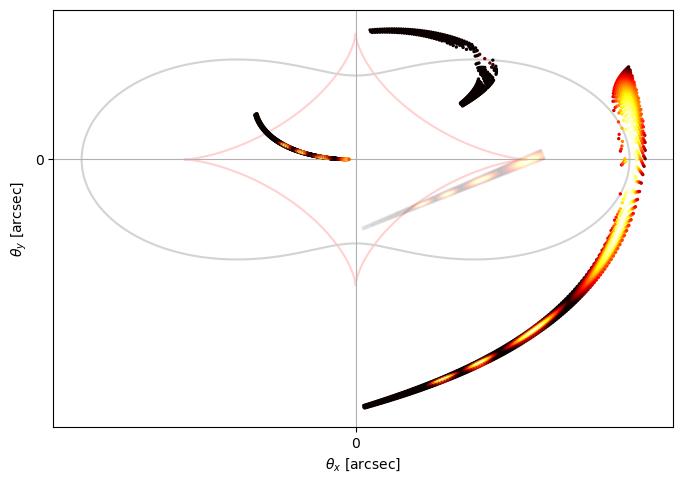

In [342]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x_rot,mesh_y_rot, s =.0005, c=mesh_light, cmap='hot',zorder = 2)
#plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
#plt.plot(x_circle1_p,y_circle1_p,color='#bae4a7',lw = 1.5,zorder=1)
# plt.plot(SSS[0][0],SSS[1][0], color = '#d3d3d3',zorder=1)
# plt.plot(SSS[2][0],SSS[3][0], color = '#d3d3d3',zorder=1)
plt.plot(SSSp2[2][0],SSSp2[3][0], color = '#ffd1d1',zorder=1)
plt.plot(SSSp2[0][0],SSSp2[1][0], color = '#d3d3d3',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_rot_p2, y_image_rot_p2, c=light_p2, cmap='hot', s = 2,zorder = 2)
plt.grid()
fig.savefig(my_path + 'image25.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

In [344]:
#nu = 60.0 * u.MHz
#nu = 130.0 * u.MHz
#nu = 110.0 * u.MHz
nu = 320.0 * u.MHz

omega = nu*(1.+zl)*2*pi
psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

In [345]:
kwargs = {'theta_E':theta_E_num.value,'eta':elipt, 'A':A, 'B':B, 'C':C,\
                'psi0_plasma':psi0_plasma.value,'theta_0':theta_0.value}
kwargs_lens_list = [kwargs]

In [346]:
x_image_rot, y_image_rot, light = main(mesh_x_rot,mesh_y_rot,mesh_light)

time:  0.28234588702519736  minutes


In [347]:
SSS = lensModelExtensions.critical_curve_caustics(kwargs_lens=kwargs_lens_list, compute_window=5, \
                                                     grid_scale=0.001)

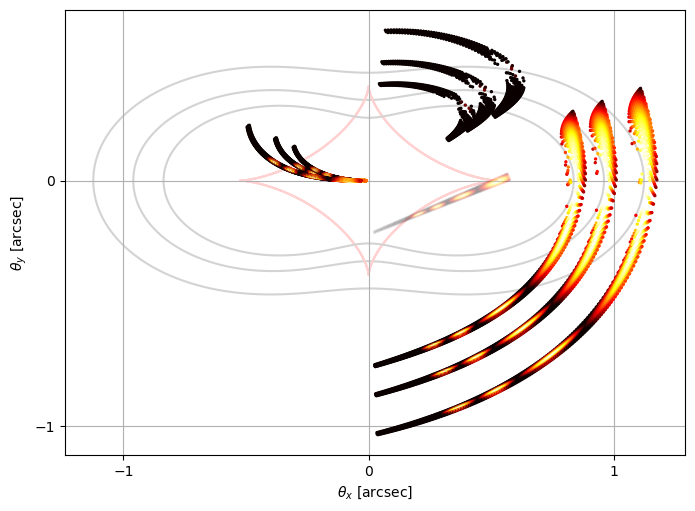

In [348]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x_rot,mesh_y_rot, s =.0005, c=mesh_light, cmap='hot',zorder = 2)
plt.plot(SSS[0][0],SSS[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSS[2][0],SSS[3][0], color = '#ffd1d1',zorder=1)
plt.plot(SSSp[2][0],SSSp[3][0], color = '#ffd1d1',zorder=1)
plt.plot(SSSp[0][0],SSSp[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSSp2[2][0],SSSp2[3][0], color = '#ffd1d1',zorder=1)
plt.plot(SSSp2[0][0],SSSp2[1][0], color = '#d3d3d3',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_rot_p, y_image_rot_p, c=light_p, cmap='hot', s = 2,zorder = 2)
plt.scatter(x_image_rot_p2, y_image_rot_p2, c=light_p2, cmap='hot', s = 2,zorder = 2)
plt.scatter(x_image_rot, y_image_rot, c=light, cmap='hot', s = 2,zorder = 2)
plt.grid()
fig.savefig(my_path + 'image25.5.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

No me cambias las **cáusticas**!!!

In [362]:
#n0 = 10./(u.cm)**(3)
#n0 = 40./(u.cm)**(3)
n0 = 300./(u.cm)**(3)
#n0 = 0.2/(u.cm)**(3)
#n0 = 200/(u.cm)**(3)

#nu = 60.0 * u.MHz
nu = 80.0 * u.MHz
#nu = 110.0 * u.MHz
#nu = 320.0 * u.MHz

omega = nu*(1.+zl)*2*pi
psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

In [363]:
kwargs = {'theta_E':theta_E_num.value,'eta':elipt, 'A':A, 'B':B, 'C':C,\
                'psi0_plasma':psi0_plasma.value,'theta_0':theta_0.value}
kwargs_lens_list = [kwargs]

In [364]:
x_image_rot_n1, y_image_rot_n1, light_n1 = main(mesh_x_rot,mesh_y_rot,mesh_light)

time:  0.26272502342859905  minutes


In [365]:
SSSn1 = lensModelExtensions.critical_curve_caustics(kwargs_lens=kwargs_lens_list, compute_window=5, \
                                                     grid_scale=0.001)

In [366]:
#n0 = 10./(u.cm)**(3)
#n0 = 40./(u.cm)**(3)
n0 = 200./(u.cm)**(3)
#n0 = 0.2/(u.cm)**(3)
#n0 = 200/(u.cm)**(3)

#nu = 60.0 * u.MHz
nu = 80.0 * u.MHz
#nu = 110.0 * u.MHz
#nu = 320.0 * u.MHz

omega = nu*(1.+zl)*2*pi
psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

In [367]:
kwargs = {'theta_E':theta_E_num.value,'eta':elipt, 'A':A, 'B':B, 'C':C,\
                'psi0_plasma':psi0_plasma.value,'theta_0':theta_0.value}
kwargs_lens_list = [kwargs]

In [368]:
x_image_rot_n2, y_image_rot_n2, light_n2 = main(mesh_x_rot,mesh_y_rot,mesh_light)

time:  0.27632142305374147  minutes


In [369]:
SSSn2 = lensModelExtensions.critical_curve_caustics(kwargs_lens=kwargs_lens_list, compute_window=5, \
                                                     grid_scale=0.001)

In [370]:
n0 = 100./(u.cm)**(3)
#n0 = 40./(u.cm)**(3)
#n0 = 300./(u.cm)**(3)
#n0 = 0.2/(u.cm)**(3)
#n0 = 200/(u.cm)**(3)

#nu = 60.0 * u.MHz
nu = 80.0 * u.MHz
#nu = 110.0 * u.MHz
#nu = 320.0 * u.MHz

omega = nu*(1.+zl)*2*pi
psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

In [371]:
kwargs = {'theta_E':theta_E_num.value,'eta':elipt, 'A':A, 'B':B, 'C':C,\
                'psi0_plasma':psi0_plasma.value,'theta_0':theta_0.value}
kwargs_lens_list = [kwargs]

In [372]:
x_image_rot_n3, y_image_rot_n3, light_n3 = main(mesh_x_rot,mesh_y_rot,mesh_light)

time:  0.29077163139979045  minutes


In [373]:
SSSn3 = lensModelExtensions.critical_curve_caustics(kwargs_lens=kwargs_lens_list, compute_window=5, \
                                                     grid_scale=0.001)

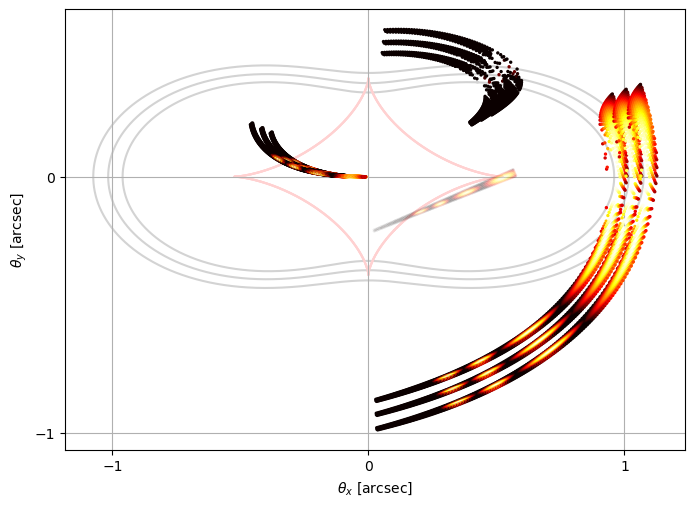

In [375]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x_rot,mesh_y_rot, s =.0005, c=mesh_light, cmap='hot',zorder = 2)
plt.plot(SSSn1[0][0],SSSn1[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSSn1[2][0],SSSn1[3][0], color = '#ffd1d1',zorder=1)
plt.plot(SSSn2[2][0],SSSn2[3][0], color = '#ffd1d1',zorder=1)
plt.plot(SSSn2[0][0],SSSn2[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSSn3[2][0],SSSn3[3][0], color = '#ffd1d1',zorder=1)
plt.plot(SSSn3[0][0],SSSn3[1][0], color = '#d3d3d3',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_rot_n1, y_image_rot_n1, c=light_n1, cmap='hot', s = 2,zorder = 2)
plt.scatter(x_image_rot_n2, y_image_rot_n2, c=light_n2, cmap='hot', s = 2,zorder = 2)
plt.scatter(x_image_rot_n3, y_image_rot_n3, c=light_n3, cmap='hot', s = 2,zorder = 2)
plt.grid()
fig.savefig(my_path + 'image25.6.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

## Pongamos el plasma de canto

## Gaussiano de canto

In [83]:
lens_model_list = ['PlasmaGaussianSIEcanto']
lensModel = LensModel(lens_model_list)
lensEquationSolver = LensEquationSolver(lensModel)

#    zero order
lens_model_list_zero = ['PlasmaGaussianSIEcanto']
lensModel_zero = LensModel(lens_model_list_zero)
lensEquationSolver_zero = LensEquationSolver(lensModel_zero)

In [84]:
#n0 = 10./(u.cm)**(3)
n0 = 40./(u.cm)**(3)
#n0 = 300./(u.cm)**(3)
#n0 = 0.2/(u.cm)**(3)
#n0 = 200/(u.cm)**(3)

#nu = 60.0 * u.MHz
#nu = 80.0 * u.MHz
nu = 130.0 * u.MHz
#nu = 110.0 * u.MHz
#nu = 375.0 * u.MHz

omega = nu*(1.+zl)*2*pi

psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

In [85]:
z0 = 1.0*u.kpc
thetaz = (z0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())
print('theta_z: ',thetaz, 'arcsec')

theta_z:  0.29240748137875755 arcsec


In [86]:
kwargs = {'theta_E':theta_E_num.value,'eta':elipt, 'A':A, 'B':B, 'C':C,\
                'thetaz':thetaz.value, 'psi0_plasma':psi0_plasma.value,'theta_0':theta_0.value}
kwargs_lens_list = [kwargs]

In [87]:
lensModelExtensions = LensModelExtensions(lensModel=lensModel)

SSSpgausscanto = lensModelExtensions.critical_curve_caustics(kwargs_lens=kwargs_lens_list, compute_window=5, \
                                                     grid_scale=0.001)

In [88]:
x_image_p_gauss_canto, y_image_p_gauss_canto, light_p_gauss_canto = main(mesh_x,mesh_y,mesh_light)

time:  0.37968430519104  minutes


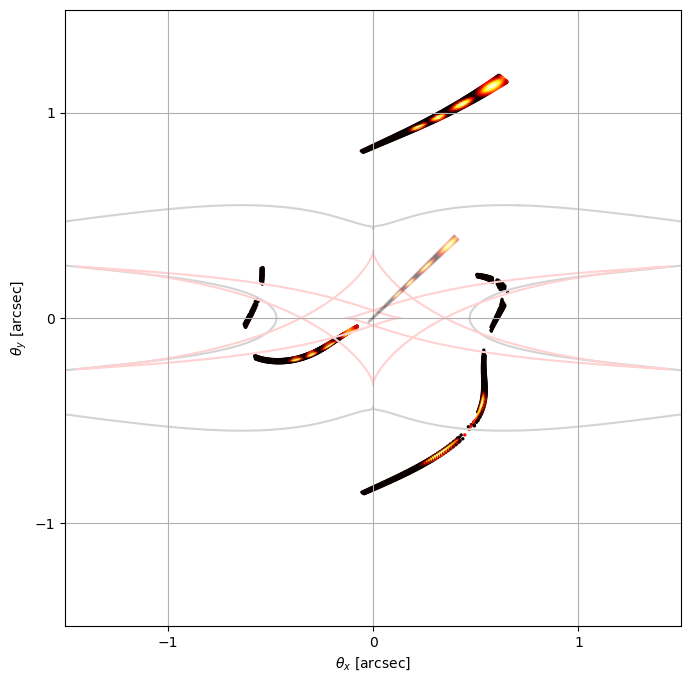

In [89]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x,mesh_y, s =.0005, c=mesh_light, cmap='hot',zorder = 2)
#plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
plt.plot(SSSpgausscanto[0][0],SSSpgausscanto[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSSpgausscanto[2][0],SSSpgausscanto[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_p_gauss_canto, y_image_p_gauss_canto, c=light_p_gauss_canto, cmap='hot', s = 2)
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
plt.grid()
fig.savefig(my_path + 'image26.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

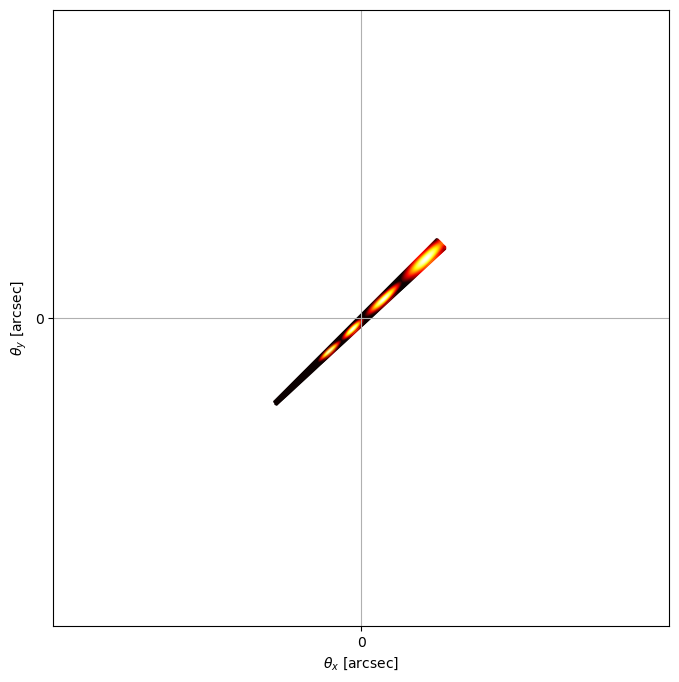

In [90]:
mesh_x_corr = np.array(mesh_x) -.2
mesh_y_corr = np.array(mesh_y) -.2

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))
plt.scatter(mesh_x_corr,mesh_y_corr , c=mesh_light, cmap='hot', s = 1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
ax.set_xlim([-.8, .8])
ax.set_ylim([-.8, .8])
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
fig.savefig(my_path + 'image27.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

In [91]:
x_image_p_gauss_canto, y_image_p_gauss_canto, light_p_gauss_canto = main(mesh_x_corr,mesh_y_corr,mesh_light)

time:  0.45302172501881915  minutes


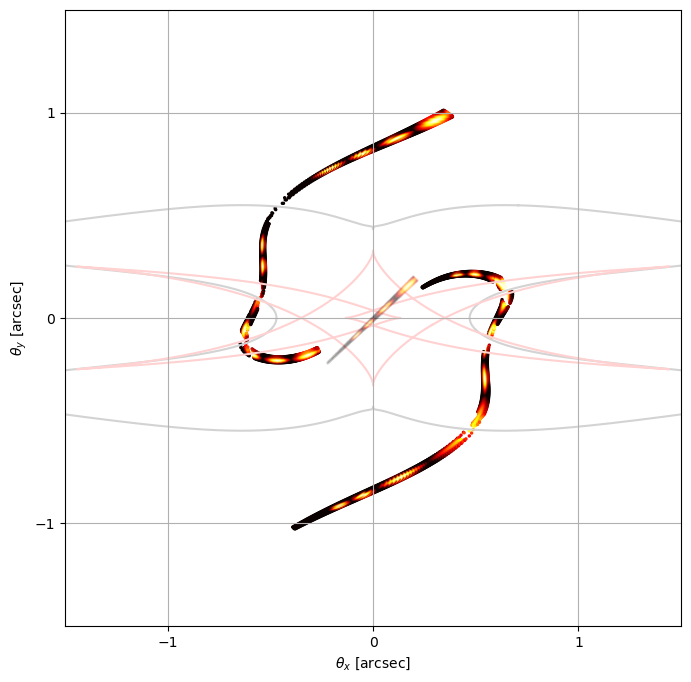

In [92]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x_corr,mesh_y_corr, s =.0005, c=mesh_light, cmap='hot',zorder = 2)
#plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
plt.plot(SSSpgausscanto[0][0],SSSpgausscanto[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSSpgausscanto[2][0],SSSpgausscanto[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_p_gauss_canto, y_image_p_gauss_canto, c=light_p_gauss_canto, cmap='hot', s = 2)
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
plt.grid()
fig.savefig(my_path + 'image28.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

### Vertical

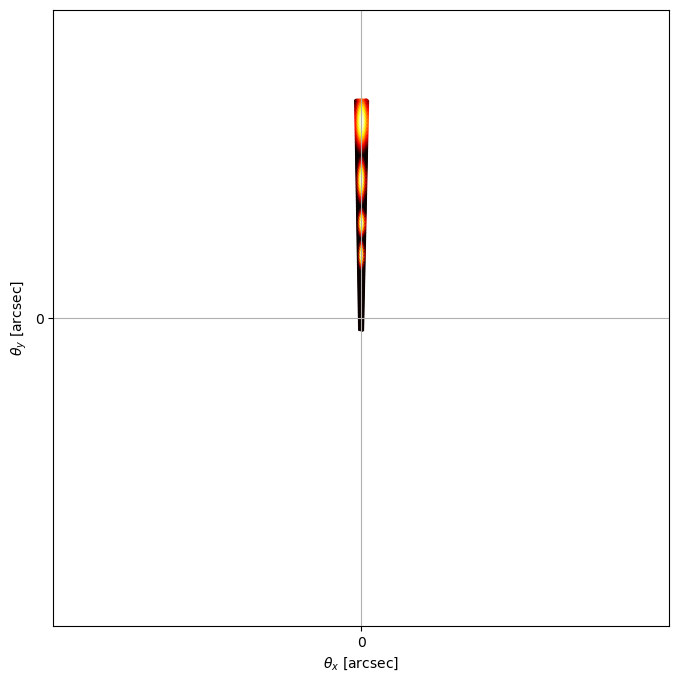

In [93]:
thetarot = np.pi/4. + np.pi/180
mesh_x_rot = np.array(mesh_x)*np.cos(thetarot) -  np.array(mesh_y)*np.sin(thetarot) 
mesh_y_rot = np.array(mesh_x)*np.sin(thetarot) +  np.array(mesh_y)*np.cos(thetarot)

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))
plt.scatter(mesh_x_rot,mesh_y_rot , c=mesh_light, cmap='hot', s = 1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
ax.set_xlim([-.8, .8])
ax.set_ylim([-.8, .8])
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
fig.savefig(my_path + 'image29.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

In [94]:
x_image_rot_1_p_gauss_canto, y_image_rot_1_p_gauss_canto, light_rot_1_p_gauss_canto = main(mesh_x_rot,mesh_y_rot,mesh_light)

time:  0.3998323162396749  minutes


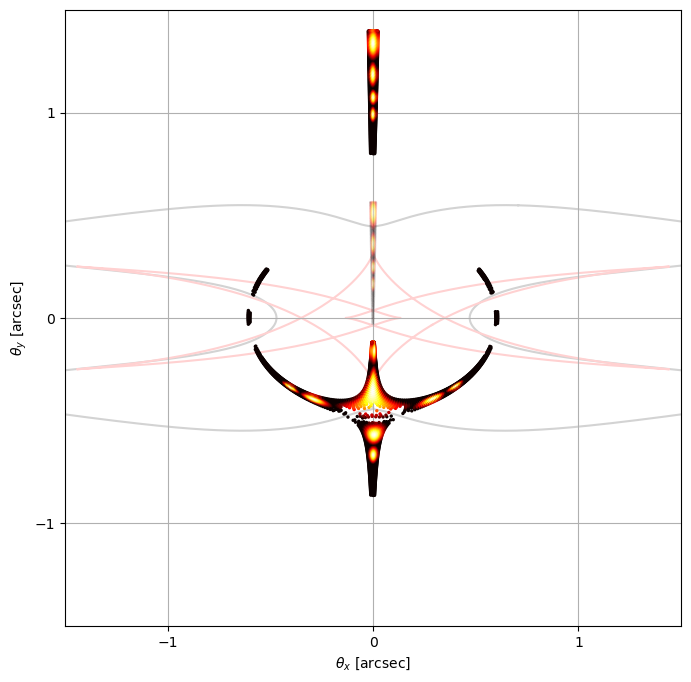

In [95]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x_rot,mesh_y_rot, s =.0005, c=mesh_light, cmap='hot',zorder = 2)
#plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
plt.plot(SSSpgausscanto[0][0],SSSpgausscanto[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSSpgausscanto[2][0],SSSpgausscanto[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_rot_1_p_gauss_canto, y_image_rot_1_p_gauss_canto, c=light_rot_1_p_gauss_canto, cmap='hot', s = 2,zorder = 2)
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
plt.grid()
fig.savefig(my_path + 'image30.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

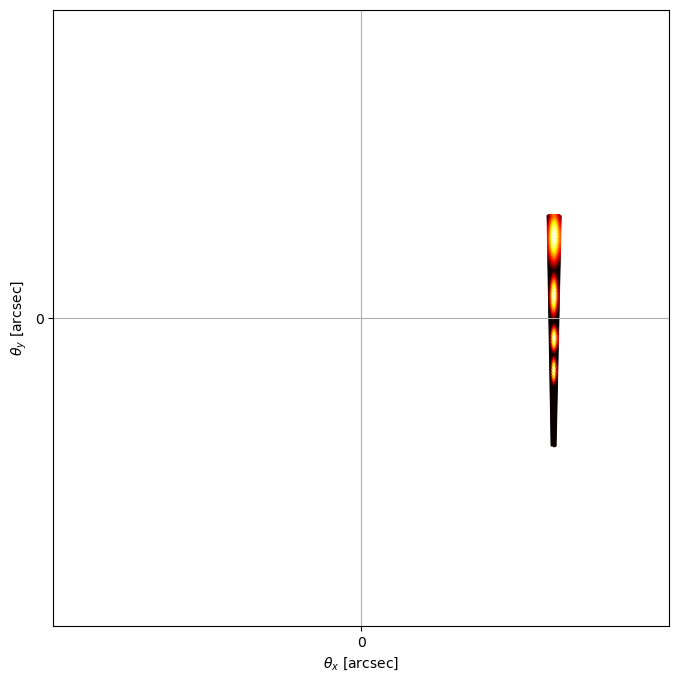

In [96]:
thetarot = np.pi/4. + np.pi/180
mesh_x_rot = np.array(mesh_x)*np.cos(thetarot) -  np.array(mesh_y)*np.sin(thetarot) + .5
mesh_y_rot = np.array(mesh_x)*np.sin(thetarot) +  np.array(mesh_y)*np.cos(thetarot) - .3

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))
plt.scatter(mesh_x_rot,mesh_y_rot , c=mesh_light, cmap='hot', s = 1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
ax.set_xlim([-.8, .8])
ax.set_ylim([-.8, .8])
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
fig.savefig(my_path + 'image31.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

In [97]:
x_image_rot_1_p_gauss_canto, y_image_rot_1_p_gauss_canto, light_rot_1_p_gauss_canto = main(mesh_x_rot,mesh_y_rot,mesh_light)

time:  0.36138023535410563  minutes


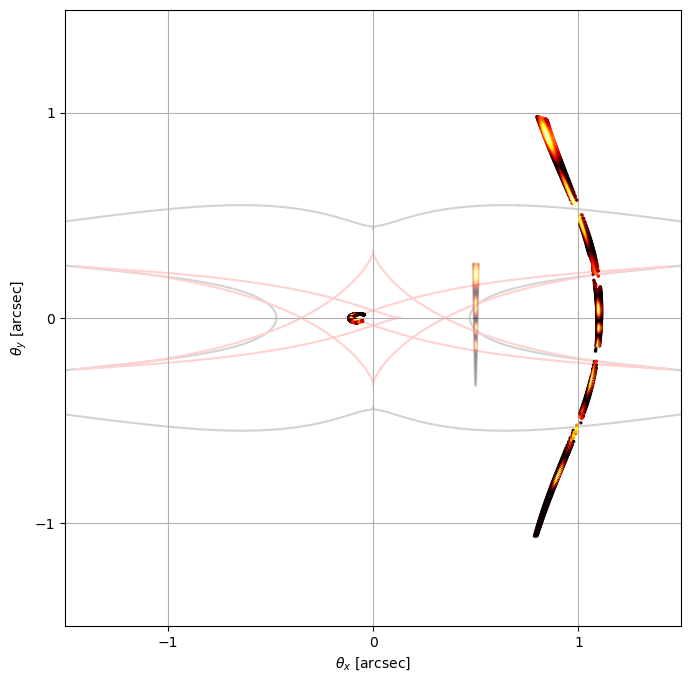

In [98]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x_rot,mesh_y_rot, s =.0005, c=mesh_light, cmap='hot',zorder = 2)
#plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
plt.plot(SSSpgausscanto[0][0],SSSpgausscanto[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSSpgausscanto[2][0],SSSpgausscanto[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_rot_1_p_gauss_canto, y_image_rot_1_p_gauss_canto, c=light_rot_1_p_gauss_canto, cmap='hot', s = 2,zorder = 2)
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
plt.grid()
fig.savefig(my_path + 'image32.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

### Horizontal

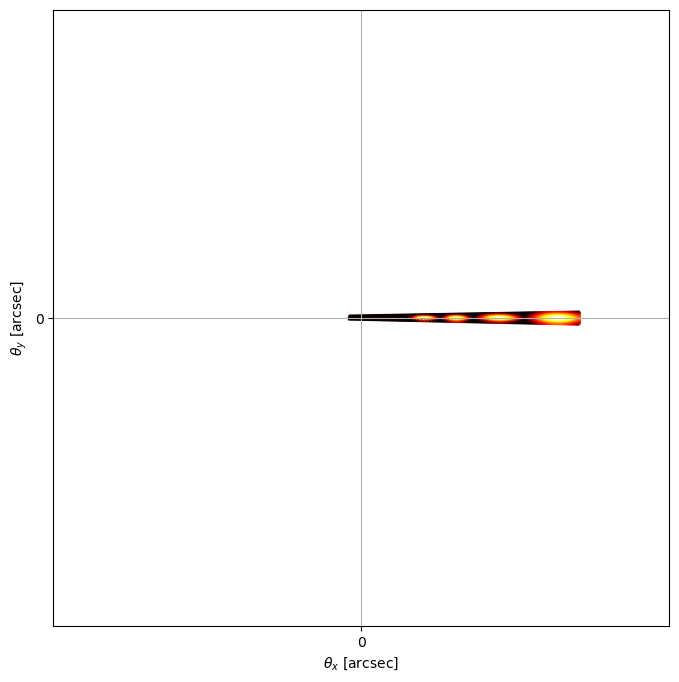

In [99]:
thetarot = -np.pi/4. + np.pi/180

mesh_x_rot = np.array(mesh_x)*np.cos(thetarot) -  np.array(mesh_y)*np.sin(thetarot)  
mesh_y_rot = np.array(mesh_x)*np.sin(thetarot) +  np.array(mesh_y)*np.cos(thetarot)

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))
plt.scatter(mesh_x_rot,mesh_y_rot , c=mesh_light, cmap='hot', s = 1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
ax.set_xlim([-.8, .8])
ax.set_ylim([-.8, .8])
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
fig.savefig(my_path + 'image33.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

In [100]:
x_image_rot_2_p_gauss_canto, y_image_rot_2_p_gauss_canto, light_rot_2_p_gauss_canto = main(mesh_x_rot,mesh_y_rot,mesh_light)

time:  0.437705393632253  minutes


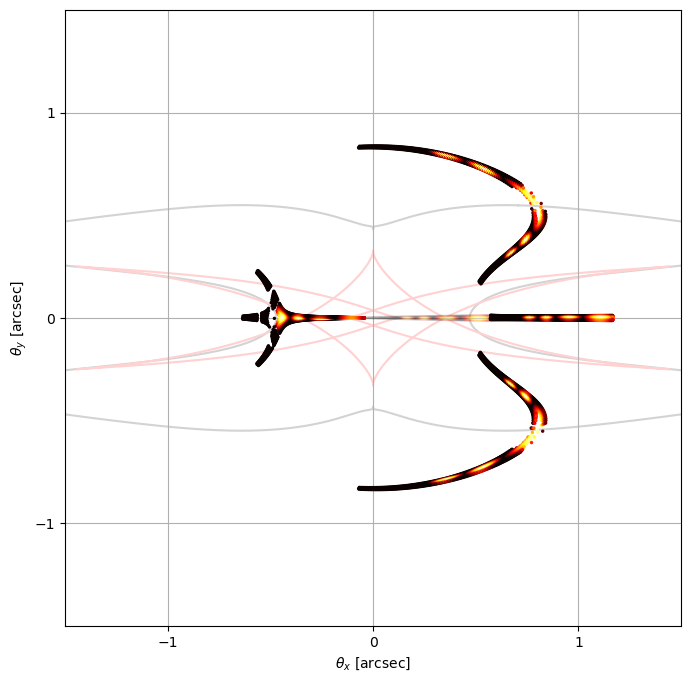

In [101]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x_rot,mesh_y_rot, s =.0005, c=mesh_light, cmap='hot',zorder = 2)
#plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
plt.plot(SSSpgausscanto[0][0],SSSpgausscanto[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSSpgausscanto[2][0],SSSpgausscanto[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_rot_2_p_gauss_canto, y_image_rot_2_p_gauss_canto, c=light_rot_2_p_gauss_canto, cmap='hot', s = 2,zorder = 2)
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
plt.grid()
fig.savefig(my_path + 'image34.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

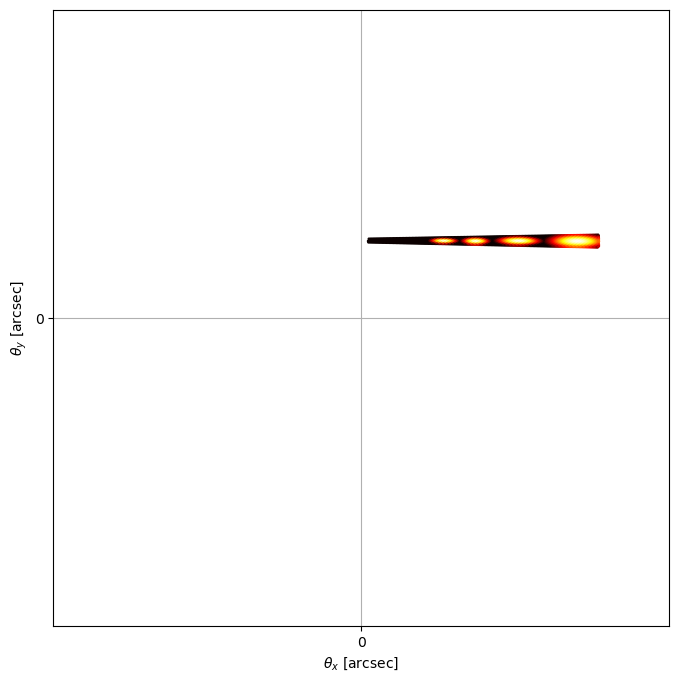

In [102]:
thetarot = -np.pi/4. + np.pi/180

mesh_x_rot = np.array(mesh_x)*np.cos(thetarot) -  np.array(mesh_y)*np.sin(thetarot)  + .05
mesh_y_rot = np.array(mesh_x)*np.sin(thetarot) +  np.array(mesh_y)*np.cos(thetarot)  + .2

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))
plt.scatter(mesh_x_rot,mesh_y_rot , c=mesh_light, cmap='hot', s = 1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
ax.set_xlim([-.8, .8])
ax.set_ylim([-.8, .8])
plt.gca().set_aspect('equal', adjustable='box')

plt.grid()
fig.savefig(my_path + 'image35.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

In [103]:
x_image_rot_2_p_gauss_canto, y_image_rot_2_p_gauss_canto, light_rot_2_p_gauss_canto = main(mesh_x_rot,mesh_y_rot,mesh_light)

time:  0.36208564837773644  minutes


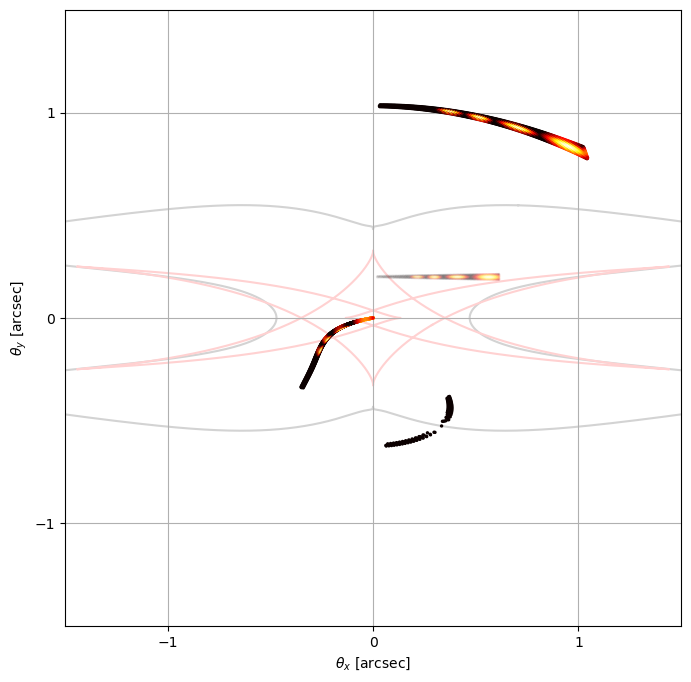

In [104]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.arange(-2., 2., 1))
ax.set_yticks(np.arange(-2., 2., 1))

plt.scatter(mesh_x_rot,mesh_y_rot, s =.0005, c=mesh_light, cmap='hot',zorder = 2)
#plt.plot(x_circle1,y_circle1,color='#bae4a7',lw = 1.5,zorder=1)
plt.plot(SSSpgausscanto[0][0],SSSpgausscanto[1][0], color = '#d3d3d3',zorder=1)
plt.plot(SSSpgausscanto[2][0],SSSpgausscanto[3][0], color = '#ffd1d1',zorder=1)
ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(x_image_rot_2_p_gauss_canto, y_image_rot_2_p_gauss_canto, c=light_rot_2_p_gauss_canto, cmap='hot', s = 2,zorder = 2)
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
plt.grid()
fig.savefig(my_path + 'image36.png', format='png', dpi = 300, bbox_inches='tight')
plt.show()

In [105]:
end_total = time.time()

print('time: ',(end_total-start_total)/60., 'minutes')

time:  9.016158016522725 minutes


asd